# Capstone Flight Estimator

<img src="files/Images/flight_estimator.png">

Flights are a significant consideration in a travellers' budget, representing up to 50% of international travel costs[<sup>1</sup>](#fn1). COVID-19 has also sent shockwaves throughout the travel industry, making it more difficult for consumers to budget appropriately for vacations. Given these trends, this Capstone investigates if Machine Learning models and techniques could be used to predict flight prices. The MVP of this project is to train a machine learning model to predict prices; however, the end goal is to create a web-based application for travellers to look up their desired itinerary and see the estimated price of a flight (airline agnostic). Flight price aggregators like Google Flights and Hopper exist; however, they are airline-dependent and often aren't ideal for long-range trip planning. Data acquisition is first required to begin tackling this business problem.


## Data Acquisition 

<img src="files/Images/data source.png">

For this project, three different data sources were used to create the data frame used for modelling. 

#### United States Department of Transportation - Bureau of Transportation Statistics  <br>
Representing the core of my data set, **Data Bank 28 Market Data** is a domestic and international traffic data report which includes U.S. and foreign airline carriers. The report features U.S. direct airline flights for 2018-2019 by quarter with the following data attributes:<br>
- **YEAR:**  The year the data occurred  <br>
- **QUARTER:**  The three month period of time the data occurred  <br>
- **ORIGIN:** The departure airport of the flight world area code  <br>
- **ORGIN_STATE_NM:** The departure airport state   <br>
- **DEST:** The destination airport for the flight world area code  <br>
- **DEST_STATE_NM:** The destination airport state  <br>
- **PASSENGERS:** The number of passengers per booking  <br>
- **MARKET_FARE:** The total air fare cost of the booking $ U.S. <br>
- **MARKET_DISTANCE:** The distance in miles between the origin and destination airport  <br>
- **DISTANCE_GROUP:** Indicates which airports are within 500 miles of each other  <br>

#### Federal Aviation Administration <br>
This department provided the **Airport Operations and Ranking Reports** which included data on the flight volume that arrived at U.S. airports by month. The full data attributes included: <br>
- **QTR_YEAR:**  The quarter and year of the data  <br>
- **Date**  The month and year of the data  <br>
- **Facility:** The airport of the flight world area code  <br>
- **State:** The state of the airport  <br>
- **Total Operations:** The flight arrival volume for the airport  <br>

#### U.S. Energy Information Administration (EIA) <br>
The EIA is responsible for collecting, analyzing, and disseminating U.S. energy information to promote the public understanding of energy and its interaction with the economy and the environment. This data source provided access to **Monthly Retail Gasoline and Diesel Prices** which included the following data attributes:
- **QTR_YEAR:**  The quarter and year of the data  <br>
- **DATE:**  The year and month of the data  <br>
- **GAS_PRICES:** The monthly average retail gap price in $ U.S. <br>

Now that the data sources have been acquired, the next step is to begin Exploratory Data Analysis.

## Exploratory Data Analysis

Import all necessary packages for data exploration, preprocessing and modelling. 

In [81]:
#Imported the relevant packages for preforming the analysis

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm
from scipy.stats import skew, mode
from scipy import sparse
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
import sklearn.model_selection as model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

### Data Importing



Due to a large amount of data within this dataset, **Amazon Sagemaker** will be used to manage the RAM required to process the data. The data is housed in pz-capstone bucket within **Amazon s3**. The data is imported, and the .head() and .info() functions are used to review the data and determine the action plan.

In [2]:
# Imports required for Sagemaker

import boto3
from sagemaker import get_execution_role
role = get_execution_role()

In [3]:
# Instantiate an S3 client

s3 = boto3.client('s3')

# Check
s3

In [4]:
# Load s3 bucket into notebook

bucket = s3.list_objects_v2(Bucket='pz-capstone')

In [5]:
#Import the data
q1_2019 = pd.read_csv('s3://pz-capstone/Q12019.csv')

In [6]:
#Import the data
q2_2019 = pd.read_csv('s3://pz-capstone/Q22019.csv')

In [7]:
#Import the data
q3_2019 = pd.read_csv('s3://pz-capstone/Q32019.csv')

In [8]:
#Import the data
q4_2019 = pd.read_csv('s3://pz-capstone/Q42019.csv')

In [9]:
#Import the data
q1_2018 = pd.read_csv('s3://pz-capstone/Q12018.csv')

In [10]:
#Import the data
q2_2018 = pd.read_csv('s3://pz-capstone/Q22018.csv')

In [11]:
#Import the data
q3_2018 = pd.read_csv('s3://pz-capstone/Q32018.csv')

In [12]:
#Import the data
q4_2018 = pd.read_csv('s3://pz-capstone/Q42018.csv')

In [13]:
#Import the data
gas = pd.read_csv('s3://pz-capstone/US Gas Prices.csv')

In [14]:
#Import the data
carr_load = pd.read_csv('s3://pz-capstone/ATADS.csv')

### Reviewing Data Tables `.head()`

#### `q1_2019`

In [15]:
#Look at the data

q1_2019.head()

,YEAR,QUARTER,ORIGIN,ORIGIN_STATE_NM,DEST,DEST_STATE_ABR,PASSENGERS,MARKET_FARE,MARKET_DISTANCE,Unnamed: 9
0,2019,1,CLT,North Carolina,RIC,VA,1.0,352.5,257.0,NaN
1,2019,1,RIC,Virginia,CLT,NC,1.0,352.5,257.0,NaN
2,2019,1,CLT,North Carolina,RIC,VA,1.0,353.0,257.0,NaN
3,2019,1,RIC,Virginia,CLT,NC,1.0,353.0,257.0,NaN
4,2019,1,CLT,North Carolina,RIC,VA,1.0,353.5,257.0,NaN


#### `q2_2019`

In [16]:
#### `q1_2019`#Look at the data

q2_2019.head()

,YEAR,QUARTER,ORIGIN,ORIGIN_STATE_NM,DEST,DEST_STATE_NM,PASSENGERS,MARKET_FARE,MARKET_DISTANCE,Unnamed: 9
0,2019,2,TPA,Florida,CLT,North Carolina,1.0,494.0,507.0,NaN
1,2019,2,CLT,North Carolina,TPA,Florida,1.0,494.5,507.0,NaN
2,2019,2,TPA,Florida,CLT,North Carolina,1.0,494.5,507.0,NaN
3,2019,2,CLT,North Carolina,TPA,Florida,1.0,498.5,507.0,NaN
4,2019,2,TPA,Florida,CLT,North Carolina,1.0,498.5,507.0,NaN


#### `q3_2019`

In [17]:
#Look at the data

q3_2019.head()

,YEAR,QUARTER,ORIGIN,ORIGIN_STATE_NM,DEST,DEST_STATE_NM,PASSENGERS,MARKET_FARE,MARKET_DISTANCE,DISTANCE_GROUP,Unnamed: 10
0,2019,3,ORD,Illinois,CLT,North Carolina,23.0,180.5,599.0,2,NaN
1,2019,3,CLT,North Carolina,ORD,Illinois,5.0,181.0,599.0,2,NaN
2,2019,3,ORD,Illinois,CLT,North Carolina,5.0,181.0,599.0,2,NaN
3,2019,3,CLT,North Carolina,ORD,Illinois,54.0,181.5,599.0,2,NaN
4,2019,3,ORD,Illinois,CLT,North Carolina,54.0,181.5,599.0,2,NaN


#### `q4_2019`

In [18]:
#Look at the data

q4_2019.head()

,YEAR,QUARTER,ORIGIN,ORIGIN_STATE_NM,DEST,DEST_STATE_NM,PASSENGERS,MARKET_FARE,MARKET_DISTANCE,Unnamed: 9
0,2019,4,SAN,California,ATL,Georgia,2.0,331.5,1892.0,NaN
1,2019,4,ATL,Georgia,SAN,California,2.0,332.5,1892.0,NaN
2,2019,4,SAN,California,ATL,Georgia,2.0,332.5,1892.0,NaN
3,2019,4,ATL,Georgia,SAN,California,8.0,333.0,1892.0,NaN
4,2019,4,SAN,California,ATL,Georgia,8.0,333.0,1892.0,NaN


#### `q1_2018`

In [19]:
#Look at the data

q1_2018.head()

,YEAR,QUARTER,ORIGIN,ORIGIN_STATE_NM,DEST,DEST_STATE_NM,PASSENGERS,MARKET_FARE,MARKET_DISTANCE,Unnamed: 9
0,2018,1,LAX,California,DCA,Virginia,1.0,311.39,2325.0,NaN
1,2018,1,DCA,Virginia,LAX,California,1.0,314.61,2349.0,NaN
2,2018,1,LAX,California,DFW,Texas,1.0,5.00,1291.0,NaN
3,2018,1,LAX,California,DFW,Texas,1.0,11.00,1291.0,NaN
4,2018,1,LAX,California,DFW,Texas,1.0,140.00,1291.0,NaN


#### `q2_2018`

In [20]:
#Look at the data

q2_2018.head()

,YEAR,QUARTER,ORIGIN,ORIGIN_STATE_NM,DEST,DEST_STATE_NM,PASSENGERS,MARKET_FARE,MARKET_DISTANCE,Unnamed: 9
0,2018,2,LAX,California,MSY,Louisiana,1.0,373.66,1670.0,NaN
1,2018,2,MSY,Louisiana,LAX,California,1.0,376.34,1682.0,NaN
2,2018,2,LAX,California,MSY,Louisiana,1.0,381.13,1670.0,NaN
3,2018,2,MSY,Louisiana,LAX,California,1.0,383.87,1682.0,NaN
4,2018,2,LAX,California,MSY,Louisiana,1.0,419.99,1670.0,NaN


#### `q3_2018`

In [21]:
#Look at the data

q3_2018.head()

,YEAR,QUARTER,ORIGIN,ORIGIN_STATE_NM,DEST,DEST_STATE_NM,PASSENGERS,MARKET_FARE,MARKET_DISTANCE,Unnamed: 9
0,2018,3,ABY,Georgia,MCI,Missouri,1.0,129.5,837.0,NaN
1,2018,3,MCI,Missouri,ABY,Georgia,1.0,140.5,837.0,NaN
2,2018,3,ABY,Georgia,MCI,Missouri,1.0,140.5,837.0,NaN
3,2018,3,MCI,Missouri,ABY,Georgia,2.0,157.0,837.0,NaN
4,2018,3,ABY,Georgia,MCI,Missouri,2.0,157.0,837.0,NaN


#### `q4_2018`

In [22]:
#Look at the data

q4_2018.head()

,YEAR,QUARTER,ORIGIN,ORIGIN_STATE_NM,DEST,DEST_STATE_NM,PASSENGERS,MARKET_FARE,MARKET_DISTANCE,Unnamed: 9
0,2018,4,DFW,Texas,PDX,Oregon,1.0,184.0,1616.0,NaN
1,2018,4,PDX,Oregon,DFW,Texas,5.0,185.0,1616.0,NaN
2,2018,4,DFW,Texas,PDX,Oregon,5.0,185.0,1616.0,NaN
3,2018,4,PDX,Oregon,DFW,Texas,5.0,185.5,1616.0,NaN
4,2018,4,DFW,Texas,PDX,Oregon,5.0,185.5,1616.0,NaN


#### `gas`

In [23]:
#Look at the data

gas.head()

,QTR_YEAR,DATE,GAS_PRICES
0,Q12018,18-Jan,2.67
1,Q12018,18-Feb,2.71
2,Q12018,18-Mar,2.71
3,Q22018,18-Apr,2.87
4,Q22018,18-May,2.99


#### `carr_load`

In [24]:
#Look at the data

carr_load.head()

,QTR_YEAR,Date,Facility,State,Total Operations
0,Q12018,01/2018,ATL,GA,69828
1,Q12018,01/2018,LAX,CA,57898
2,Q12018,01/2018,ORD,IL,69419
3,Q12018,01/2018,DFW,TX,53120
4,Q12018,01/2018,DEN,CO,46882


### Reviewing Data Format `.info()`

**Q1 2019**

In [25]:
#Reviewing Data Tables structure using .info()

q1_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6508753 entries, 0 to 6508752
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   YEAR             int64  
 1   QUARTER          int64  
 2   ORIGIN           object 
 3   ORIGIN_STATE_NM  object 
 4   DEST             object 
 5   DEST_STATE_ABR   object 
 6   PASSENGERS       float64
 7   MARKET_FARE      float64
 8   MARKET_DISTANCE  float64
 9   Unnamed: 9       float64
dtypes: float64(4), int64(2), object(4)
memory usage: 496.6+ MB


**Q2 2019**

In [26]:
#Reviewing Data Tables structure using .info()

q2_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7465479 entries, 0 to 7465478
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   YEAR             int64  
 1   QUARTER          int64  
 2   ORIGIN           object 
 3   ORIGIN_STATE_NM  object 
 4   DEST             object 
 5   DEST_STATE_NM    object 
 6   PASSENGERS       float64
 7   MARKET_FARE      float64
 8   MARKET_DISTANCE  float64
 9   Unnamed: 9       float64
dtypes: float64(4), int64(2), object(4)
memory usage: 569.6+ MB


**Q3 2019**

In [27]:
#Reviewing Data Tables structure using .info()

q3_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7141323 entries, 0 to 7141322
Data columns (total 11 columns):
 #   Column           Dtype  
---  ------           -----  
 0   YEAR             int64  
 1   QUARTER          int64  
 2   ORIGIN           object 
 3   ORIGIN_STATE_NM  object 
 4   DEST             object 
 5   DEST_STATE_NM    object 
 6   PASSENGERS       float64
 7   MARKET_FARE      float64
 8   MARKET_DISTANCE  float64
 9   DISTANCE_GROUP   int64  
 10  Unnamed: 10      float64
dtypes: float64(4), int64(3), object(4)
memory usage: 599.3+ MB


**Q4 2019**

In [28]:
#Reviewing Data Tables structure using .info()

q4_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7420339 entries, 0 to 7420338
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   YEAR             int64  
 1   QUARTER          int64  
 2   ORIGIN           object 
 3   ORIGIN_STATE_NM  object 
 4   DEST             object 
 5   DEST_STATE_NM    object 
 6   PASSENGERS       float64
 7   MARKET_FARE      float64
 8   MARKET_DISTANCE  float64
 9   Unnamed: 9       float64
dtypes: float64(4), int64(2), object(4)
memory usage: 566.1+ MB


**Q1 2018**

In [29]:
#Reviewing Data Tables structure using .info()

q1_2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6093175 entries, 0 to 6093174
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   YEAR             int64  
 1   QUARTER          int64  
 2   ORIGIN           object 
 3   ORIGIN_STATE_NM  object 
 4   DEST             object 
 5   DEST_STATE_NM    object 
 6   PASSENGERS       float64
 7   MARKET_FARE      float64
 8   MARKET_DISTANCE  float64
 9   Unnamed: 9       float64
dtypes: float64(4), int64(2), object(4)
memory usage: 464.9+ MB


**Q2 2018**

In [30]:
#Reviewing Data Tables structure using .info()

q2_2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7149085 entries, 0 to 7149084
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   YEAR             int64  
 1   QUARTER          int64  
 2   ORIGIN           object 
 3   ORIGIN_STATE_NM  object 
 4   DEST             object 
 5   DEST_STATE_NM    object 
 6   PASSENGERS       float64
 7   MARKET_FARE      float64
 8   MARKET_DISTANCE  float64
 9   Unnamed: 9       float64
dtypes: float64(4), int64(2), object(4)
memory usage: 545.4+ MB


**Q3 2018**

In [31]:
#Reviewing Data Tables structure using .info()

q3_2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6816253 entries, 0 to 6816252
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   YEAR             int64  
 1   QUARTER          int64  
 2   ORIGIN           object 
 3   ORIGIN_STATE_NM  object 
 4   DEST             object 
 5   DEST_STATE_NM    object 
 6   PASSENGERS       float64
 7   MARKET_FARE      float64
 8   MARKET_DISTANCE  float64
 9   Unnamed: 9       float64
dtypes: float64(4), int64(2), object(4)
memory usage: 520.0+ MB


**Q4 2018**

In [32]:
#Reviewing Data Tables structure using .info()

q4_2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7176258 entries, 0 to 7176257
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   YEAR             int64  
 1   QUARTER          int64  
 2   ORIGIN           object 
 3   ORIGIN_STATE_NM  object 
 4   DEST             object 
 5   DEST_STATE_NM    object 
 6   PASSENGERS       float64
 7   MARKET_FARE      float64
 8   MARKET_DISTANCE  float64
 9   Unnamed: 9       float64
dtypes: float64(4), int64(2), object(4)
memory usage: 547.5+ MB


**Gas**

In [33]:
#Reviewing Data Tables structure using .info()

gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   QTR_YEAR      36 non-null     object 
 1   DATE          36 non-null     object 
 2    GAS_PRICES   36 non-null     float64
dtypes: float64(1), object(2)
memory usage: 1.1+ KB


**carr_load**

In [34]:
#Reviewing Data Tables structure using .info()

carr_load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18696 entries, 0 to 18695
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   QTR_YEAR          18696 non-null  object
 1   Date              18696 non-null  object
 2   Facility          18696 non-null  object
 3   State             18696 non-null  object
 4   Total Operations  18696 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 730.4+ KB


## Action Plan:

After reviewing the data, the following course of action will be taken and `.head()` or `.info()` will be used throughout to confirm the change occurred:

-  For `gas`, the average gas price will be calculated by `QTR_YEAR` using the `groupby()` and `.agg(mean)` to make it aligned with the core dataset.  
-  The column names for `gas` and `carr_load` will be updated to align the naming convention for the data.
-   In `carr_load` there are date gaps in `Facility`; as a result, the average flight volume for each destination will be used instead. This will be achieved by using `groupby()` on `Facility` and `.agg(mean)`.
-   The flights .csv's will be merged into one data frame.
-  `PASSENGERS`/ `MARKET_DISTANCE` converted into integers to save memory space.
-  `QUARTER` / `YEAR` will be converter to a string to prepare the column to have a character added.
-   A new column will be made `QTR_YEAR` and `QUARTER` and `YEAR` will be dropped as they are no longer required.
-   Another column will be created that calculates the flight price per passenger. It will be called `AVG_FLIGHT_PRICE` as `MARKET_FARE` is the total cost of the booking which may include several passengers.
-   All of the data frames will be merged using `concat()` to simplify the data cleaning process.
-   The following columns will be dropped as they are not required for the analysis `DISTANCE_GROUP`, `Unnamed: 10`, `Unnamed: 9` and `DEST_STATE_ABR`. 
-   Move `AVG_FLIGHT_PRICE` and `QTR_YEAR` to the front of the data frame to support modelling and visualizations.
-	A Null_checker function created to check for nulls within the data.
-	Column names updated for table format consistency.
-   Categorical data fields converted into numerical values using `get_dummies` and append to the data frame to support model performance.



### `gas_df` Updates

**Calculate the Average Gas Price by Quarter**

In [35]:

#Create an average gas price table

gas_df = gas.groupby('QTR_YEAR').agg(['mean'])
gas_df.columns = gas_df.columns.droplevel(0)
gas_df


,mean
QTR_YEAR,
Q12018,2.696667
Q12019,2.440000
Q12020,2.500000
Q22018,2.943333
Q22019,2.876667
Q22020,2.023333
Q32018,2.920000
Q32019,2.736667
Q32020,2.270000


**Column Name Update**

In [36]:
#Rename the column

gas_df.rename(columns={'mean':'AVG_GAS_PRICES'}, inplace=True)
gas_df.head()

,AVG_GAS_PRICES
QTR_YEAR,
Q12018,2.696667
Q12019,2.440000
Q12020,2.500000
Q22018,2.943333
Q22019,2.876667


### `carr_load` Updates


**Column Name Update**

In [37]:
#Rename the column

carr_load.rename(columns={'Total Operations':'TOTAL_OPS'}, inplace=True)
carr_load.head()

,QTR_YEAR,Date,Facility,State,TOTAL_OPS
0,Q12018,01/2018,ATL,GA,69828
1,Q12018,01/2018,LAX,CA,57898
2,Q12018,01/2018,ORD,IL,69419
3,Q12018,01/2018,DFW,TX,53120
4,Q12018,01/2018,DEN,CO,46882


**Calculate the Average Volume by Destination**

In [38]:
#Create an average flight volume by destination table

carr_load = carr_load.groupby('Facility').agg(['mean'])
carr_load.columns = carr_load.columns.droplevel(0)
carr_load.head()

,mean
Facility,
ABE,6330.277778
ABI,4082.888889
ABQ,11504.916667
ABY,1359.777778
ACK,5672.888889


**Column Name Update, Rounding and Data Type Change**

In [39]:
#Rename the column
#Round the calculated field value and and make it an integer to save memory 

carr_load.rename(columns={'mean':'AVG_FLIGHT_VOL'}, inplace=True)
carr_load.AVG_FLIGHT_VOL = carr_load.AVG_FLIGHT_VOL.round(0).astype(int)
carr_load.head()

,AVG_FLIGHT_VOL
Facility,
ABE,6330
ABI,4083
ABQ,11505
ABY,1360
ACK,5673


### Merging the Data Frames 

Since the data sets have the same columns and are structured the same way now I will use the `concat` function to combine the data sets.

**Merge the Flight data into a Data Frames**

In [40]:
# Consolidate the flight data into one Data Frame and using head() to review the outcome

flight_df = pd.concat([
    q1_2019,
    q2_2019,
    q3_2019,
    q4_2019,
    q1_2018,
    q2_2018,
    q3_2018,
    q4_2018,
],
axis=0)
flight_df.reset_index(drop=True, inplace=True)

print('The newly created Flight data frame.')
flight_df.head()

The newly created Flight data frame.


,YEAR,QUARTER,ORIGIN,ORIGIN_STATE_NM,DEST,DEST_STATE_ABR,PASSENGERS,MARKET_FARE,MARKET_DISTANCE,Unnamed: 9,DEST_STATE_NM,DISTANCE_GROUP,Unnamed: 10
0,2019,1,CLT,North Carolina,RIC,VA,1.0,352.5,257.0,NaN,NaN,NaN,NaN
1,2019,1,RIC,Virginia,CLT,NC,1.0,352.5,257.0,NaN,NaN,NaN,NaN
2,2019,1,CLT,North Carolina,RIC,VA,1.0,353.0,257.0,NaN,NaN,NaN,NaN
3,2019,1,RIC,Virginia,CLT,NC,1.0,353.0,257.0,NaN,NaN,NaN,NaN
4,2019,1,CLT,North Carolina,RIC,VA,1.0,353.5,257.0,NaN,NaN,NaN,NaN


In [41]:
#Check the shape of the merged data frame

print(f'Demensions of the Flight Data Frame: {flight_df.shape}')

Demensions of the Flight Data Frame: (55770665, 13)


### Convert `PASSENGERS`and `MARKET_DISTANCE` into an Integer

In [42]:
#Convert float columns to int to decrease memory usage and confirm it was executed by using .info()
#Convert the `QUARTER` and `YEAR to a string in preparation 

flight_df.PASSENGERS = flight_df.PASSENGERS.round(0).astype(int)
flight_df.MARKET_DISTANCE = flight_df.MARKET_DISTANCE.round(0).astype(int)
flight_df.QUARTER = flight_df.QUARTER.astype(str)
flight_df.YEAR = flight_df.YEAR.astype(str)

In [43]:
#Check to see the column data type change from float to an integer was successful 

flight_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55770665 entries, 0 to 55770664
Data columns (total 13 columns):
 #   Column           Dtype  
---  ------           -----  
 0   YEAR             object 
 1   QUARTER          object 
 2   ORIGIN           object 
 3   ORIGIN_STATE_NM  object 
 4   DEST             object 
 5   DEST_STATE_ABR   object 
 6   PASSENGERS       int64  
 7   MARKET_FARE      float64
 8   MARKET_DISTANCE  int64  
 9   Unnamed: 9       float64
 10  DEST_STATE_NM    object 
 11  DISTANCE_GROUP   float64
 12  Unnamed: 10      float64
dtypes: float64(4), int64(2), object(7)
memory usage: 5.4+ GB


### Create a new column for the `QTR_YEAR`

The new column is created by merging `QTR` AND `YEAR` together and adding a **Q** to the beginning.  `QTR` AND `YEAR` will then be dropped as it's no longer required. 

In [44]:
#Create a new column for the quarter and year
q = 'Q'

flight_df["QTR_YEAR"] = str(q) + flight_df["QUARTER"]+ flight_df["YEAR"]
flight_df.head()

,YEAR,QUARTER,ORIGIN,ORIGIN_STATE_NM,DEST,DEST_STATE_ABR,PASSENGERS,MARKET_FARE,MARKET_DISTANCE,Unnamed: 9,DEST_STATE_NM,DISTANCE_GROUP,Unnamed: 10,QTR_YEAR
0,2019,1,CLT,North Carolina,RIC,VA,1,352.5,257,NaN,NaN,NaN,NaN,Q12019
1,2019,1,RIC,Virginia,CLT,NC,1,352.5,257,NaN,NaN,NaN,NaN,Q12019
2,2019,1,CLT,North Carolina,RIC,VA,1,353.0,257,NaN,NaN,NaN,NaN,Q12019
3,2019,1,RIC,Virginia,CLT,NC,1,353.0,257,NaN,NaN,NaN,NaN,Q12019
4,2019,1,CLT,North Carolina,RIC,VA,1,353.5,257,NaN,NaN,NaN,NaN,Q12019


In [45]:
#Confirm the data format of the newly created column and drop Quarter and Year

flight_df = flight_df.drop(['QUARTER', 'YEAR'], axis=1)
flight_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55770665 entries, 0 to 55770664
Data columns (total 12 columns):
 #   Column           Dtype  
---  ------           -----  
 0   ORIGIN           object 
 1   ORIGIN_STATE_NM  object 
 2   DEST             object 
 3   DEST_STATE_ABR   object 
 4   PASSENGERS       int64  
 5   MARKET_FARE      float64
 6   MARKET_DISTANCE  int64  
 7   Unnamed: 9       float64
 8   DEST_STATE_NM    object 
 9   DISTANCE_GROUP   float64
 10  Unnamed: 10      float64
 11  QTR_YEAR         object 
dtypes: float64(4), int64(2), object(6)
memory usage: 5.0+ GB


### Create an `AVG_FLIGHT_PRICE` column within `flight_df`

The new column is created by dividing `MARKET_FARE` by `PASSENGERS` to determine the flight cost per person.

In [46]:
#Make a new column the provides the average flight price per passenger

flight_df["AVG_FLIGHT_PRICE"] = flight_df["MARKET_FARE"]/ flight_df["PASSENGERS"]
flight_df.sample(10).T

,5856603,44806738,36461460,51261347,31684336,45856008,44920406,30031812,44317695,49300491
ORIGIN,PDX,MSN,SAT,CLT,DCA,CHA,GEG,BOS,SAN,PHX
ORIGIN_STATE_NM,Oregon,Wisconsin,Texas,North Carolina,Virginia,Tennessee,Washington,Massachusetts,California,Arizona
DEST,CLE,LGA,STL,SYR,CLT,EWR,SEA,TPA,FLL,BOI
DEST_STATE_ABR,OH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PASSENGERS,1,3,1,3,6,1,1,1,1,3
MARKET_FARE,102,299,165.7,347,261,184,191,151.39,338.08,143
MARKET_DISTANCE,2587,812,786,603,331,718,224,1352,2326,735
Unnamed: 9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEST_STATE_NM,NaN,New York,Missouri,New York,North Carolina,New Jersey,Washington,Florida,Florida,Idaho
DISTANCE_GROUP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Merge `flight_df` and `gas_df` Data Frames

To perform this merge a left join on the `flight_df` data frame will be done using `QTR_YEAR`.

In [47]:
#Join with the flight_df and gas_df

flight_df1 = pd.merge(flight_df, gas_df, on='QTR_YEAR', how='left')
flight_df1.head()

,ORIGIN,ORIGIN_STATE_NM,DEST,DEST_STATE_ABR,PASSENGERS,MARKET_FARE,MARKET_DISTANCE,Unnamed: 9,DEST_STATE_NM,DISTANCE_GROUP,Unnamed: 10,QTR_YEAR,AVG_FLIGHT_PRICE,AVG_GAS_PRICES
0,CLT,North Carolina,RIC,VA,1,352.5,257,NaN,NaN,NaN,NaN,Q12019,352.5,2.44
1,RIC,Virginia,CLT,NC,1,352.5,257,NaN,NaN,NaN,NaN,Q12019,352.5,2.44
2,CLT,North Carolina,RIC,VA,1,353.0,257,NaN,NaN,NaN,NaN,Q12019,353.0,2.44
3,RIC,Virginia,CLT,NC,1,353.0,257,NaN,NaN,NaN,NaN,Q12019,353.0,2.44
4,CLT,North Carolina,RIC,VA,1,353.5,257,NaN,NaN,NaN,NaN,Q12019,353.5,2.44


### Merge the `flight_df1` and `carr_load` Data Frames

To perform this operations a right join will be performed on `DEST` and `Facility`.

In [48]:
#Join with the flight_df and carr_load data frames

flight_df2 = pd.merge(flight_df1, carr_load, left_on='DEST', right_on='Facility')
flight_df2.head()

,ORIGIN,ORIGIN_STATE_NM,DEST,DEST_STATE_ABR,PASSENGERS,MARKET_FARE,MARKET_DISTANCE,Unnamed: 9,DEST_STATE_NM,DISTANCE_GROUP,Unnamed: 10,QTR_YEAR,AVG_FLIGHT_PRICE,AVG_GAS_PRICES,AVG_FLIGHT_VOL
0,CLT,North Carolina,RIC,VA,1,352.5,257,NaN,NaN,NaN,NaN,Q12019,352.5,2.44,7698
1,CLT,North Carolina,RIC,VA,1,353.0,257,NaN,NaN,NaN,NaN,Q12019,353.0,2.44,7698
2,CLT,North Carolina,RIC,VA,1,353.5,257,NaN,NaN,NaN,NaN,Q12019,353.5,2.44,7698
3,CLT,North Carolina,RIC,VA,1,353.5,257,NaN,NaN,NaN,NaN,Q12019,353.5,2.44,7698
4,CLT,North Carolina,RIC,VA,1,356.5,257,NaN,NaN,NaN,NaN,Q12019,356.5,2.44,7698


### Drop Non-Required Columns

`DISTANCE_GROUP`, `Unnamed: 10`, `Unnamed: 9`, and `DEST_STATE_ABR` are not required for the analysis will now be dropped.


In [49]:
# Drop the column and confirm the update was made using .info() 

flight_df2.drop(['DISTANCE_GROUP', 'Unnamed: 10', 'Unnamed: 9', 'DEST_STATE_ABR'], axis=1, inplace=True)
flight_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55061231 entries, 0 to 55061230
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   ORIGIN            object 
 1   ORIGIN_STATE_NM   object 
 2   DEST              object 
 3   PASSENGERS        int64  
 4   MARKET_FARE       float64
 5   MARKET_DISTANCE   int64  
 6   DEST_STATE_NM     object 
 7   QTR_YEAR          object 
 8   AVG_FLIGHT_PRICE  float64
 9   AVG_GAS_PRICES    float64
 10  AVG_FLIGHT_VOL    int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 4.9+ GB


### Moving `AVG_FLIGHT_PRICE` and `QTR_YEAR` to the front

`AVG_FLIGHT_PRICE` and `QTR_YEAR` will be moved to the front.

In [50]:
#to prepare for the analysis I'm going to move the position of 'relative votes' to position [1]
#as it's the dependant variable and reset the index.

flight_df3 = flight_df2[['AVG_FLIGHT_PRICE', 'QTR_YEAR', 'PASSENGERS', 'MARKET_FARE', 'MARKET_DISTANCE',
    'AVG_GAS_PRICES', 'ORIGIN', 'ORIGIN_STATE_NM', 'DEST', 'DEST_STATE_NM'
]]
flight_df3.head().T

,0,1,2,3,4
AVG_FLIGHT_PRICE,352.5,353,353.5,353.5,356.5
QTR_YEAR,Q12019,Q12019,Q12019,Q12019,Q12019
PASSENGERS,1,1,1,1,1
MARKET_FARE,352.5,353,353.5,353.5,356.5
MARKET_DISTANCE,257,257,257,257,257
AVG_GAS_PRICES,2.44,2.44,2.44,2.44,2.44
ORIGIN,CLT,CLT,CLT,CLT,CLT
ORIGIN_STATE_NM,North Carolina,North Carolina,North Carolina,North Carolina,North Carolina
DEST,RIC,RIC,RIC,RIC,RIC
DEST_STATE_NM,NaN,NaN,NaN,NaN,NaN


### Null Check

**Null_Checker Function**

To support with data clean-up a null_checker function has been created which will total the null percentage for each column if it's above 0 and return a rounded percentage.


In [51]:
#Create a function to look at the null values


def null_checker(data_df):
    '''
        This function reads the dataframe provided
        and displays the columns that have
        null and the percentage
        of null within the column
    '''
    null_checker = 100* data_df.isna().sum()/data_df.shape[0]
    
    print(np.round(null_checker[null_checker > 0], 2))

**Null Check for `flight_df3`**

In [52]:
#display a summary of the nulls

null_checker(flight_df3)

DEST_STATE_NM    11.67
dtype: float64


Reviewing the nulls, 11.67% of the `DEST_STATE_NM` are null values. Opportunities to input this data will be explored by filter the data frame based on null values and looking at the unique values within the `DEST` column. This action will help identify if mode could be used to impute the missing values.

**Filter Null Values**

In [53]:
#filter the null values

nulls_filter_df = flight_df3.loc[pd.isnull(flight_df3.DEST_STATE_NM)]
nulls_filter_df

,AVG_FLIGHT_PRICE,QTR_YEAR,PASSENGERS,MARKET_FARE,MARKET_DISTANCE,AVG_GAS_PRICES,ORIGIN,ORIGIN_STATE_NM,DEST,DEST_STATE_NM
0,352.50,Q12019,1,352.50,257,2.44,CLT,North Carolina,RIC,NaN
1,353.00,Q12019,1,353.00,257,2.44,CLT,North Carolina,RIC,NaN
2,353.50,Q12019,1,353.50,257,2.44,CLT,North Carolina,RIC,NaN
3,353.50,Q12019,1,353.50,257,2.44,CLT,North Carolina,RIC,NaN
4,356.50,Q12019,1,356.50,257,2.44,CLT,North Carolina,RIC,NaN
...,...,...,...,...,...,...,...,...,...,...
55053919,38.00,Q12019,8,304.00,1025,2.44,SFB,Florida,RFD,NaN
55053920,31.70,Q12019,10,317.00,1025,2.44,SFB,Florida,RFD,NaN
55053921,318.00,Q12019,1,318.00,1025,2.44,SFB,Florida,RFD,NaN
55060442,465.31,Q12019,1,465.31,2953,2.44,SEA,Washington,GLH,NaN


**Unique Nulls within `DEST`**

In [54]:
#Unique 'DEST' values that have nulls

nulls_filter_df = flight_df3['DEST'].unique() 
nulls_filter_df

array(['RIC', 'CLT', 'DFW', 'CVG', 'GSP', 'DAY', 'LGA', 'PVD', 'MIA',
       'OMA', 'ORD', 'PHF', 'PHL', 'ROA', 'SYR', 'ROC', 'BOS', 'IND',
       'RSW', 'BNA', 'CAE', 'CAK', 'CMH', 'TOL', 'TYS', 'DEN', 'EYW',
       'FLL', 'TPA', 'SAN', 'BFL', 'SRQ', 'SDF', 'FAT', 'HNL', 'LAX',
       'EGE', 'RNO', 'SFO', 'ONT', 'PHX', 'OAK', 'SMF', 'SAT', 'ATL',
       'EWR', 'GSO', 'LYH', 'PBI', 'ABQ', 'DCA', 'SGF', 'STL', 'JFK',
       'SEA', 'SAV', 'SBY', 'ALW', 'ANC', 'BLI', 'BZN', 'MYR', 'EUG',
       'FAI', 'GEG', 'JNU', 'MFR', 'PDX', 'MCO', 'PSC', 'YKM', 'CHS',
       'RDU', 'LAS', 'KOA', 'OGG', 'SBP', 'SJC', 'SJU', 'SLC', 'JAN',
       'JAX', 'GNV', 'LEX', 'LIT', 'MCI', 'MDT', 'MEM', 'MGM', 'MHT',
       'MKE', 'MLB', 'MOB', 'MSN', 'MSP', 'MSY', 'OKC', 'GRR', 'ORF',
       'PWM', 'TUS', 'PIT', 'FAY', 'PNS', 'BHM', 'TUL', 'ABI', 'AMA',
       'ASE', 'AUS', 'BIL', 'BIS', 'BOI', 'BPT', 'BRO', 'BTR', 'CLL',
       'COS', 'COU', 'CRP', 'CYS', 'DSM', 'ELP', 'FAR', 'FSM', 'GRI',
       'ITO', 'HOU',

Based on the list above, the missing values in `DEST_STATE_NM` can be imputed using the `.groupby()` on the `DEST` and using `lambda` to fill in the mode since these values are present in the data just missing from these fields. The `null_checker()` will then be used again to confirm the command was actioned.

In [55]:
#groupby 'DEST'and input the mode into 'DEST_STATE_NM' using the lambda function

flight_df3['DEST_STATE_NM'] = flight_df3.groupby(
    ['DEST'],
    sort=False)['DEST_STATE_NM'].apply(lambda x: x.fillna(x.mode().iloc[0]))

**Null Checker**

In [56]:
#Check to see the nulls have been removed. 

null_checker(flight_df3)

Series([], dtype: float64)


### NY Flights Data Frame

There are **63MM observations** within this dataset, making it difficult to run this notebook. As a result, the project's scope will be narrowed to focus on flights originating from **John F. Kennedy (JFK) airport in New York City**. JFK is one of the busiest airports in the United States and reduced the record count to a more manageable **810,601**. 
<img src="files/Images/Data Funnel Image.png">


In [57]:
# Create a Data Frame that isolates the flight with an orgin from JFK

flight_ny_df = flight_df3[(flight_df3['ORIGIN'] == 'JFK')]
flight_ny_df.reset_index(drop=True, inplace = True)                                               
flight_ny_df.head()

,AVG_FLIGHT_PRICE,QTR_YEAR,PASSENGERS,MARKET_FARE,MARKET_DISTANCE,AVG_GAS_PRICES,ORIGIN,ORIGIN_STATE_NM,DEST,DEST_STATE_NM
0,208.1,Q12019,1,208.1,288,2.44,JFK,New York,RIC,Virginia
1,5.5,Q12019,1,5.5,288,2.44,JFK,New York,RIC,Virginia
2,88.0,Q12019,1,88.0,288,2.44,JFK,New York,RIC,Virginia
3,98.0,Q12019,1,98.0,288,2.44,JFK,New York,RIC,Virginia
4,98.0,Q12019,1,98.0,288,2.44,JFK,New York,RIC,Virginia


In [58]:
#Review the demensions of the data frame

print(f"Flight NY data frame demensions {flight_ny_df.shape}.")

Flight NY data frame demensions (810601, 10).


# Data Visualizations

The data is now sufficiently clean to begin data visualization and the continued exploration of the data. Before turning the categorical data into numerical values, a few visualizations are required to view patterns within the data. 

### Feature Pair Plot

Using Seaborn, the features of the data set are graphed against each other. It's clear that there are outliers with `MARKET_FARE`  and `AVG_FLIGHT_PRICE`, which may skew the performance of the model. This will be kept in consideration throughout the modelling process.

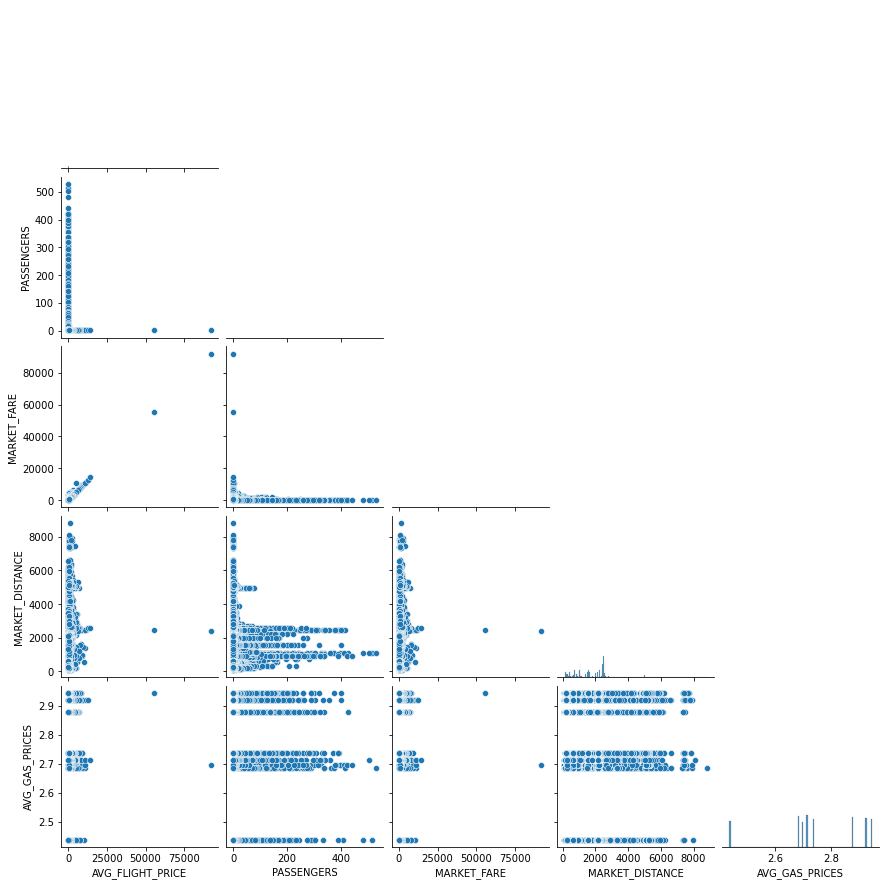

In [59]:
#Visualize the data frame features

sns.pairplot(flight_ny_df, corner=True)

### Feature Sub-plot Visualization
Matplotlib is used to create histograms of the features to see if any apparent data consistencies appear. Based on the graphs below, there is no apparent pattern except with `QTR_YEAR` , which has seasonality curves within the data. 

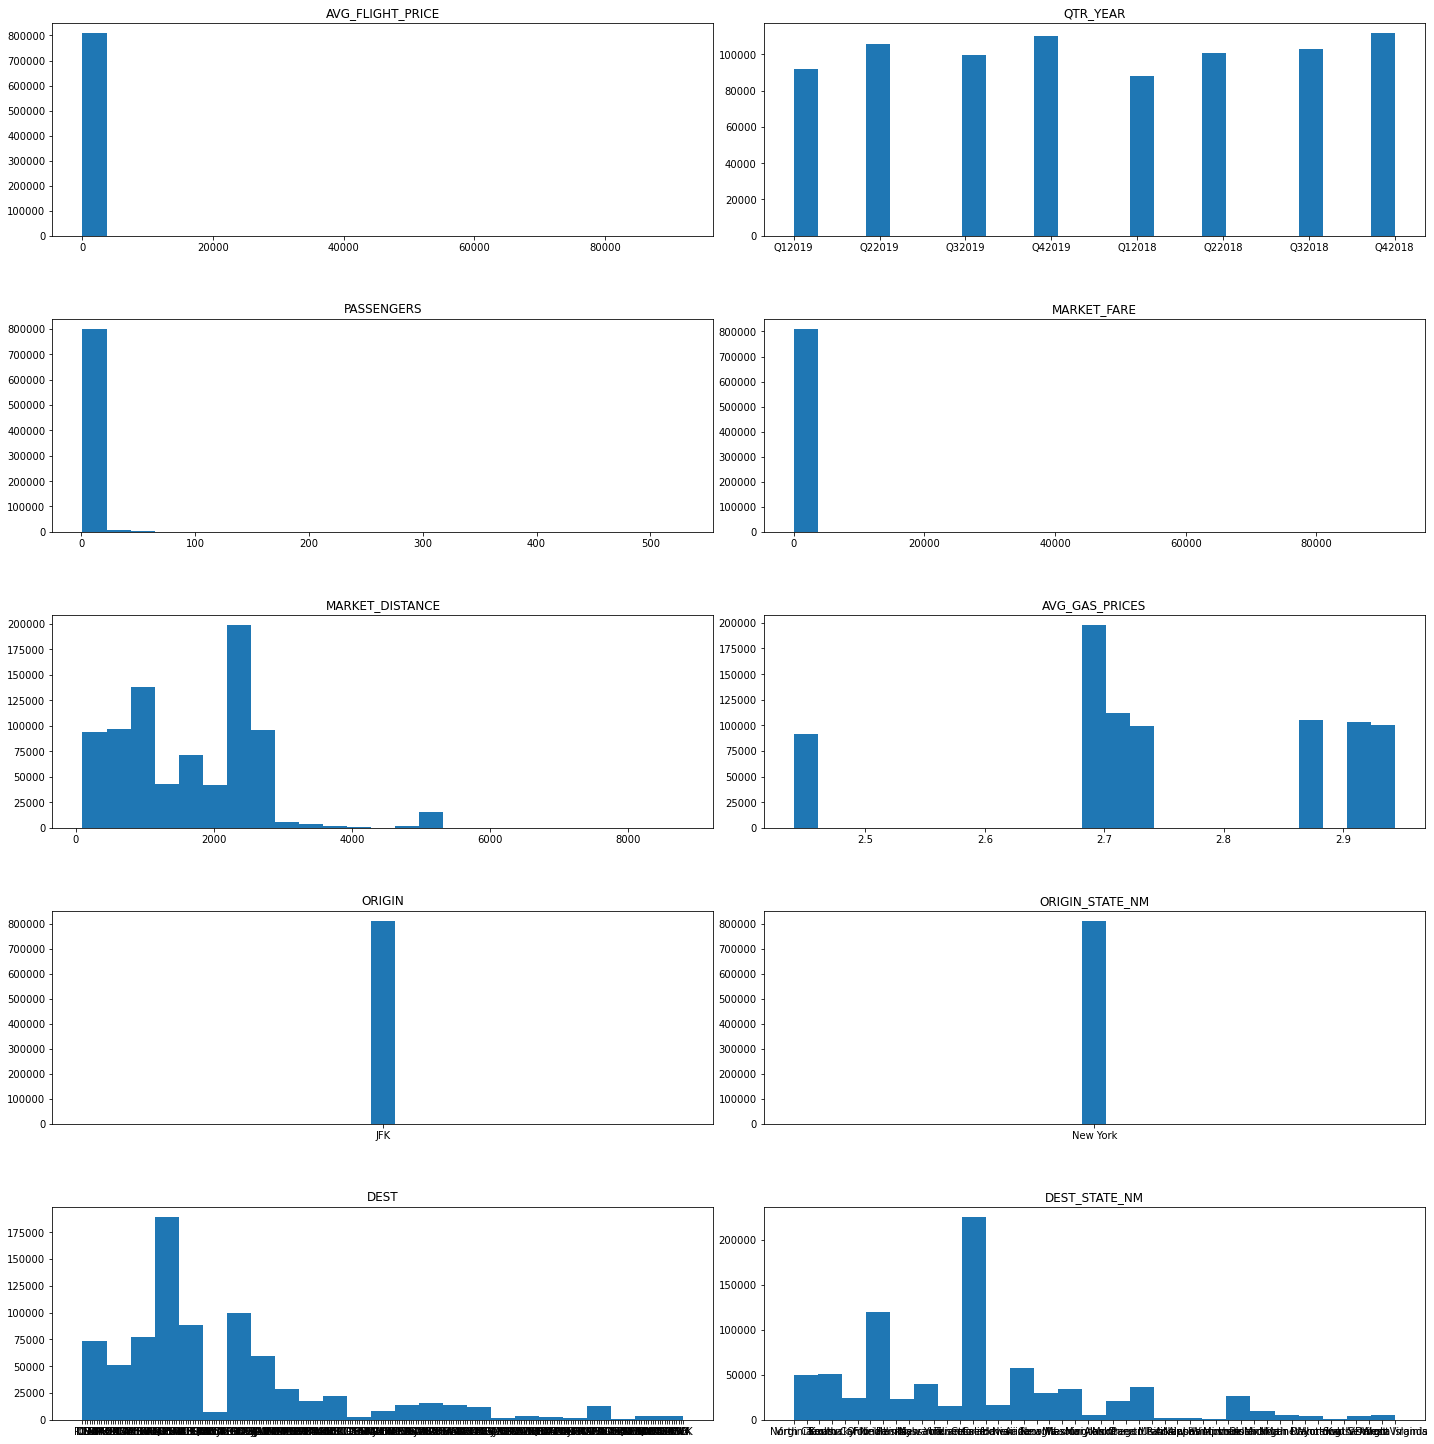

In [60]:
#Plot the features to see if there are any anolomies


# Setting the plots layout
plt.subplots(5,2, figsize=(20,20))

# Plotting
for i, column in enumerate(flight_ny_df.columns, 1):
    plt.subplot(5,2,i)
    plt.hist(flight_ny_df[column], bins=25)
    plt.title(column)
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5.0)
plt.show()


### The Relationship between Distance and Flight Price

This visualization clearly shows the pricing outliers, which could be as high as $100K. These extreme outliers may be due to chartered planes for individual use. Another pattern observed within the data is increasing flight costs for the same distance, representing different fare classes such as first-class or price seasonality. The price outliers need to be further investigated. 

Text(-9.075000000000003, 0.5, 'Flight Price')

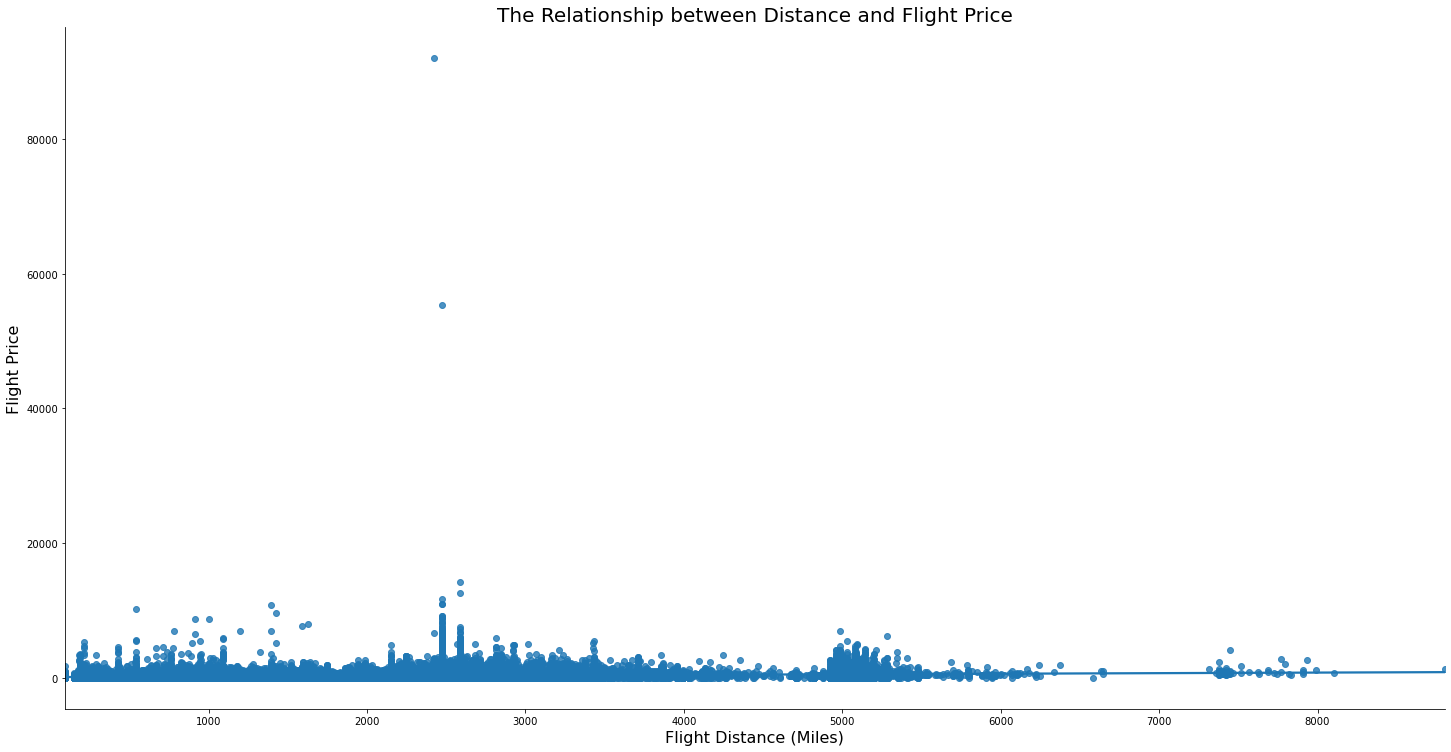

In [62]:
#Plot Price vs. distance relationship

sns.lmplot('MARKET_DISTANCE', 'AVG_FLIGHT_PRICE',
           data=flight_ny_df, height=10, aspect=2)
plt.title('The Relationship between Distance and Flight Price', fontsize=20)
plt.xlabel('Flight Distance (Miles)', fontsize=16)
plt.ylabel('Flight Price', fontsize=16)

### Summary Statistics

Pulled the data summary statistics using `.describe()`. This view was not very informative so additional analysis will be required to identify outliers.

In [62]:
#Review the summary stats to determine if there are any outliers within the data

flight_df3.describe()

,AVG_FLIGHT_PRICE,PASSENGERS,MARKET_FARE,MARKET_DISTANCE,AVG_GAS_PRICES
count,5.506123e+07,5.506123e+07,5.506123e+07,5.506123e+07,5.506123e+07
mean,2.225442e+02,2.089486e+00,2.500912e+02,1.327979e+03,2.755684e+00
std,1.780968e+03,5.923400e+00,1.782577e+03,8.283879e+02,1.506525e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,1.100000e+01,2.440000e+00
25%,9.375000e+01,1.000000e+00,1.430000e+02,7.240000e+02,2.696667e+00
50%,1.910000e+02,1.000000e+00,2.150000e+02,1.111000e+03,2.736667e+00
75%,2.980000e+02,1.000000e+00,3.140000e+02,1.811000e+03,2.920000e+00
max,8.785800e+06,9.280000e+02,8.785800e+06,1.316500e+04,2.943333e+00


### Variable Correlation Heatmap

The following data frame was created to see how correlated the variables are to one another. A heatmap was then used to depict the information visually. The heatmap indicates that most data points have a weak correlation to the dependant variable of `AVG_FLIGHT_PRICE` except `MARKET_FARE`; this may impact model performance. Additional variables will need to be found to improve the correlation with the dependant variable in future updates. The variable correlation will be re-visited based on the averages for the variables to see if this trend continues. 

In [63]:
# Correlation between independent variables

flight_ny_df_corr = pd.DataFrame(flight_ny_df.corr())
flight_ny_df_corr

,AVG_FLIGHT_PRICE,PASSENGERS,MARKET_FARE,MARKET_DISTANCE,AVG_GAS_PRICES
AVG_FLIGHT_PRICE,1.000000,-0.149595,0.936074,0.248908,-0.010758
PASSENGERS,-0.149595,1.000000,-0.067974,0.002611,0.002778
MARKET_FARE,0.936074,-0.067974,1.000000,0.280498,-0.007565
MARKET_DISTANCE,0.248908,0.002611,0.280498,1.000000,0.003816
AVG_GAS_PRICES,-0.010758,0.002778,-0.007565,0.003816,1.000000


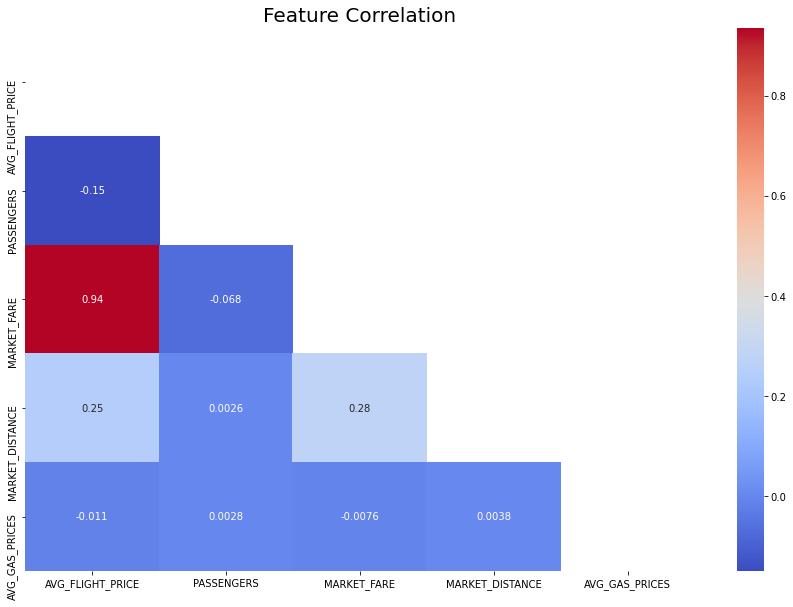

In [64]:
# Correlation of the variables in a heatmap

plt.figure(figsize=(15,10))
matrix = np.triu(flight_ny_df.corr())
sns.heatmap(flight_ny_df.corr(), annot=True, mask=matrix, cmap='coolwarm')
plt.title('Feature Correlation', size=20)
plt.show()

### Flight Volume by Quarter

The following data frame is created to develop visualizations that will show the total volume by quarter. Passenger, fare and miles flown volume increased in 2019, and there were seasonal volume peaks in Q2 and Q4, most likely due to the summer and winter holidays. 

In [65]:
#Create a data frame to plot the overall volume

flight_vol = flight_df3.groupby('QTR_YEAR').sum().reset_index()
flight_vol = flight_vol.drop(['AVG_FLIGHT_PRICE', 'AVG_GAS_PRICES'], axis=1)
flight_vol.to_csv('flight_vol.csv')
flight_vol

,QTR_YEAR,PASSENGERS,MARKET_FARE,MARKET_DISTANCE
0,Q12018,12674984,1.498030e+09,7977461215
1,Q12019,13221463,1.584509e+09,8513460457
2,Q22018,14719514,1.779631e+09,9426947966
3,Q22019,15362918,1.885916e+09,9839167901
4,Q32018,14373562,1.663564e+09,9098919781
5,Q32019,15011662,1.745020e+09,9449763293
6,Q42018,14519955,1.770332e+09,9269212715
7,Q42019,15165598,1.843326e+09,9545213462


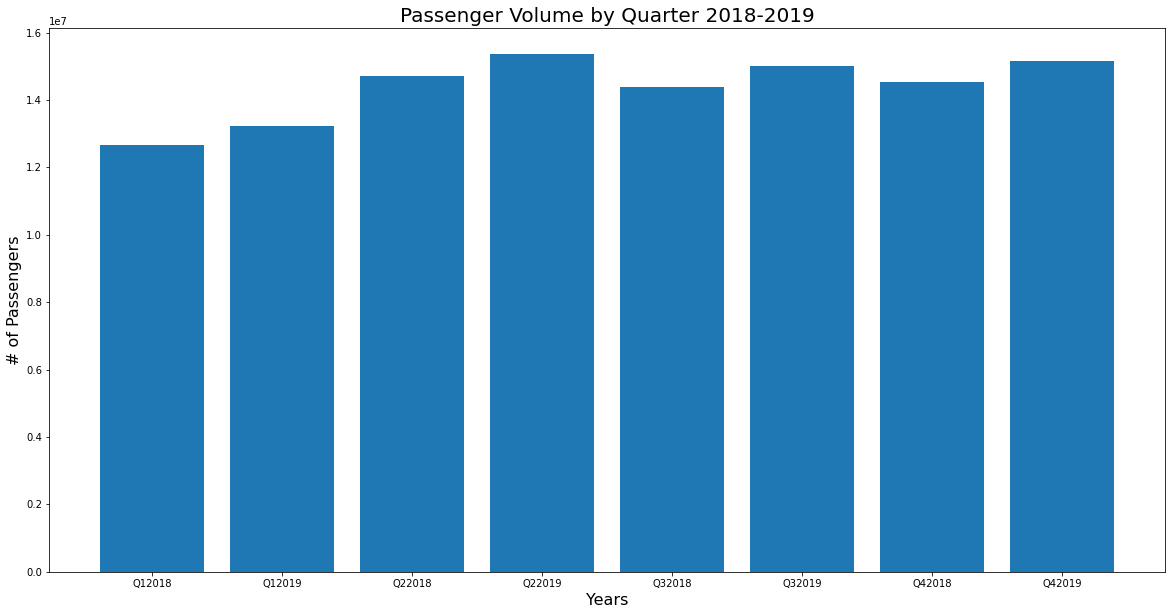

In [66]:
#Plot the passenger volume over the years


x_v = flight_vol['QTR_YEAR']
y_v = flight_vol['PASSENGERS']


plt.figure(figsize=(20,10))
plt.bar(x_v, y_v)
plt.xlabel('Years', size=16)
plt.ylabel('# of Passengers', size=16)
plt.title('Passenger Volume by Quarter 2018-2019', size=20)
plt.show()

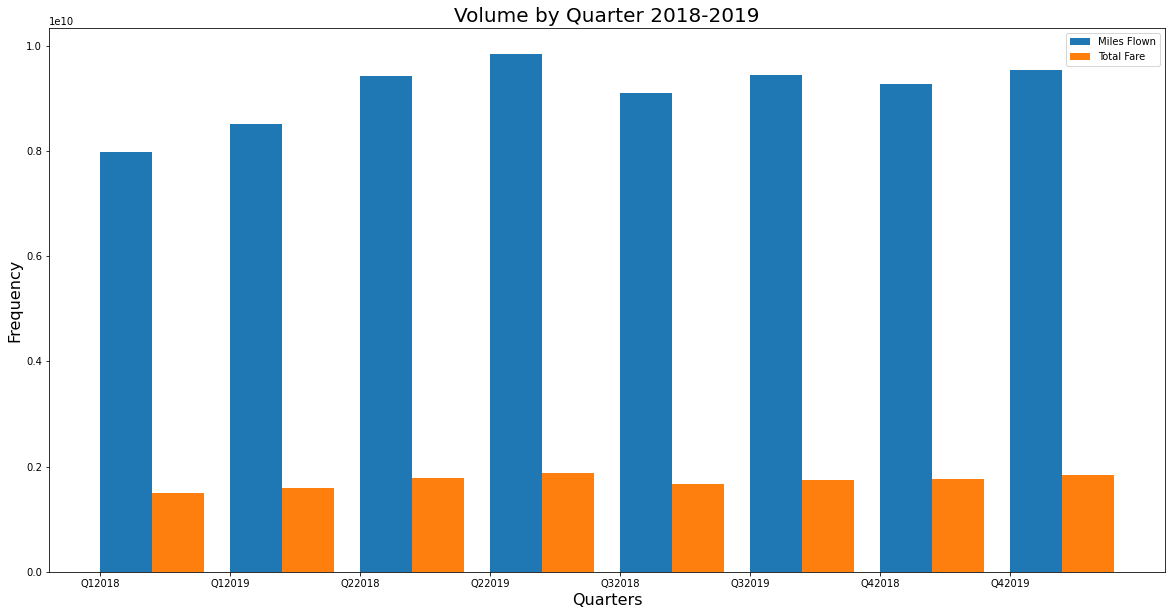

In [67]:
# Create graph of miles and market fare volume

fig = plt.subplots(figsize =(20, 10))
 

# set variables for graph
X = flight_vol['QTR_YEAR']
md = flight_vol['MARKET_DISTANCE'] 
mf = flight_vol['MARKET_FARE'] 
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis + 0.2, md, 0.4, label = 'Miles Flown')
plt.bar(X_axis + 0.6, mf, 0.4, label = 'Total Fare')
  
plt.xticks(X_axis, X)
plt.xlabel("Quarters", size=16)
plt.ylabel("Frequency", size=16)
plt.title("Volume by Quarter 2018-2019", size=20)
plt.legend()
plt.show()


### Top 20 Destination

The next data frame is created to develop visualizations that will show the top destinations based on bookings within the data set. The list of top destinations is similar to the overall highest volume airports in America. Atlanta airport is deemed the busiest airport in America; however, it's only fourth within this list. Most likely due to the large amount of business travel that occurs for LAX, ORD and SFO.

In [68]:
#Created a data frame to see the top 20 destinations

x_dest = pd.DataFrame(flight_df2['DEST'].value_counts()[:20].sort_values(ascending=False))
x_dest.to_csv('x_dest.csv')
x_dest

,DEST
LAX,1770925
ORD,1472472
DEN,1398058
ATL,1350034
SFO,1324397
SEA,1320100
BOS,1234197
MCO,1215242
LAS,1193662
LGA,1116745


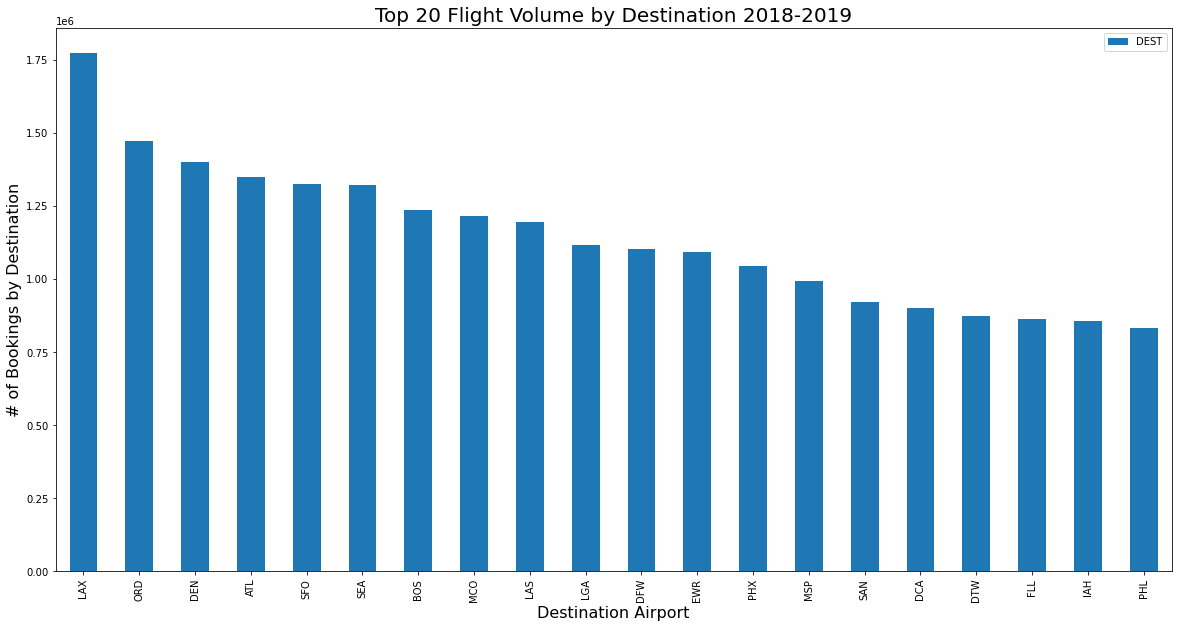

In [69]:
#Top 20 destination airports

ax = x_dest.plot.bar(y='DEST', rot=90, figsize=(20,10))
plt.xlabel('Destination Airport', size=16)
plt.ylabel('# of Bookings by Destination', size=16)
plt.title('Top 20 Flight Volume by Destination 2018-2019', size=20)
plt.show()

### Flight Volume by State

At a state level, the volume skews towards eastern states, which is logical due to New York's position as the largest city within the eastern coast. 

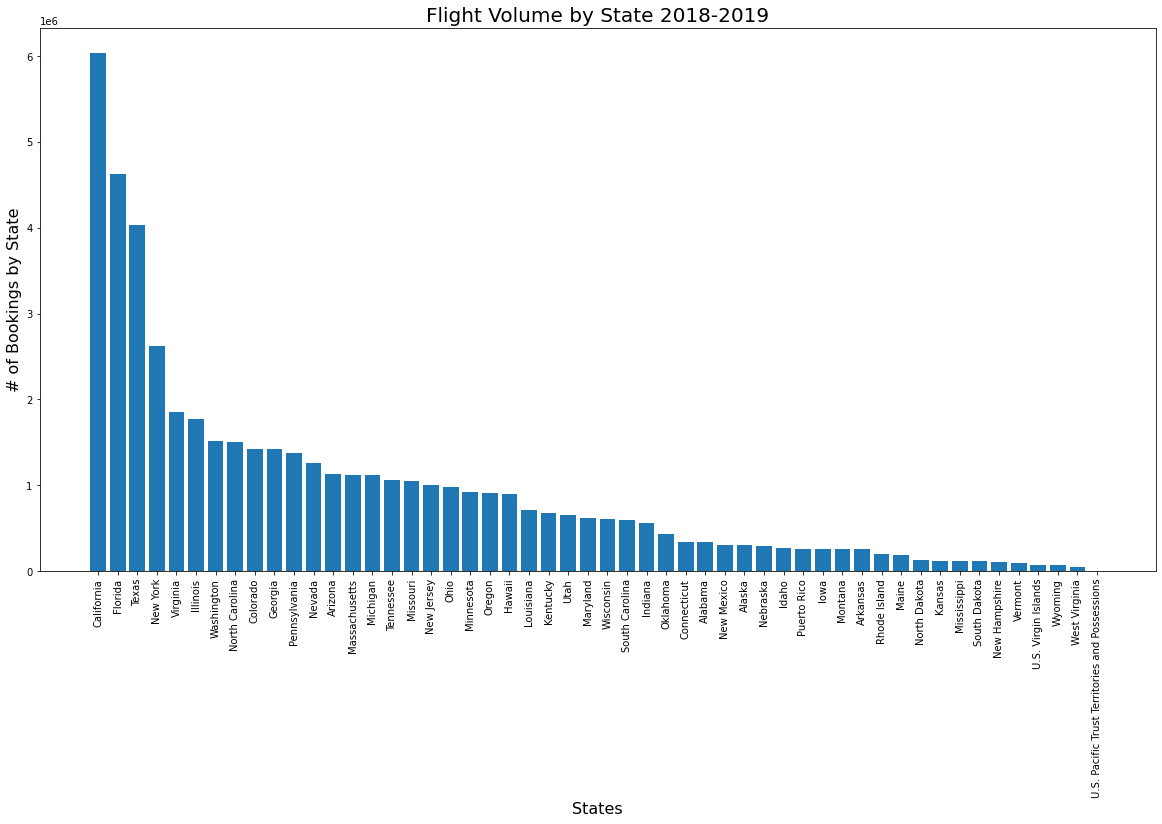

In [70]:
#Plot the frequency by state over the years

plt.figure(figsize=(20,10))
plt.bar(flight_df2['DEST_STATE_NM'].value_counts().index,
        flight_df2['DEST_STATE_NM'].value_counts().values)
plt.xticks(rotation=90)
plt.xlabel('States', size=16)
plt.ylabel('# of Bookings by State', size=16)
plt.title('Flight Volume by State 2018-2019', size=20)
plt.show()

### Averages Deep Dive

Since the dependent variable is based on averages, the below deep drive looks into the data to see any relevant patterns based on the averages for each quarter.  

#### Averages Volume by Quarter

The following data frame is created to develop visualizations that will show the average volume by quarter. Relative to the Avg. Gas Price, there is minimal movement to the Avg. Passenger number quarter over quarter (QoQ). The Avg. Flight Price and Miles Flown is another story. Interestingly these data sets have different peaks and values. Prices are lowest in Q3; however, inversely, this is when the Miles Flown is longest. A correlation heatmap will help dive into this phenomenon and determine the relationship between these features.

In [71]:
#Created a data frame to visualize the averages throughout the quarters

avg = flight_df3.groupby('QTR_YEAR').agg(['mean']).reset_index()
avg = avg.drop(['MARKET_FARE'], axis=1)
avg.columns = avg.columns.droplevel(1)
avg.rename(columns={'PASSENGERS':'AVG_PASSENGERS', 'MARKET_FARE':'AVG_MARKET_FARE', 'MARKET_DISTANCE' : 'AVG_DISTANCE'}, inplace=True)
avg

,QTR_YEAR,AVG_FLIGHT_PRICE,AVG_PASSENGERS,AVG_DISTANCE,AVG_GAS_PRICES
0,Q12018,222.415365,2.105710,1325.304969,2.696667
1,Q12019,220.075409,2.058049,1325.202985,2.440000
2,Q22018,224.193478,2.082633,1333.799107,2.943333
3,Q22019,227.849522,2.084564,1335.057463,2.876667
4,Q32018,219.724654,2.137104,1352.854785,2.920000
5,Q32019,219.725560,2.133086,1342.766463,2.736667
6,Q42018,222.171813,2.047721,1307.218804,2.713333
7,Q42019,223.543138,2.070108,1302.924008,2.686667


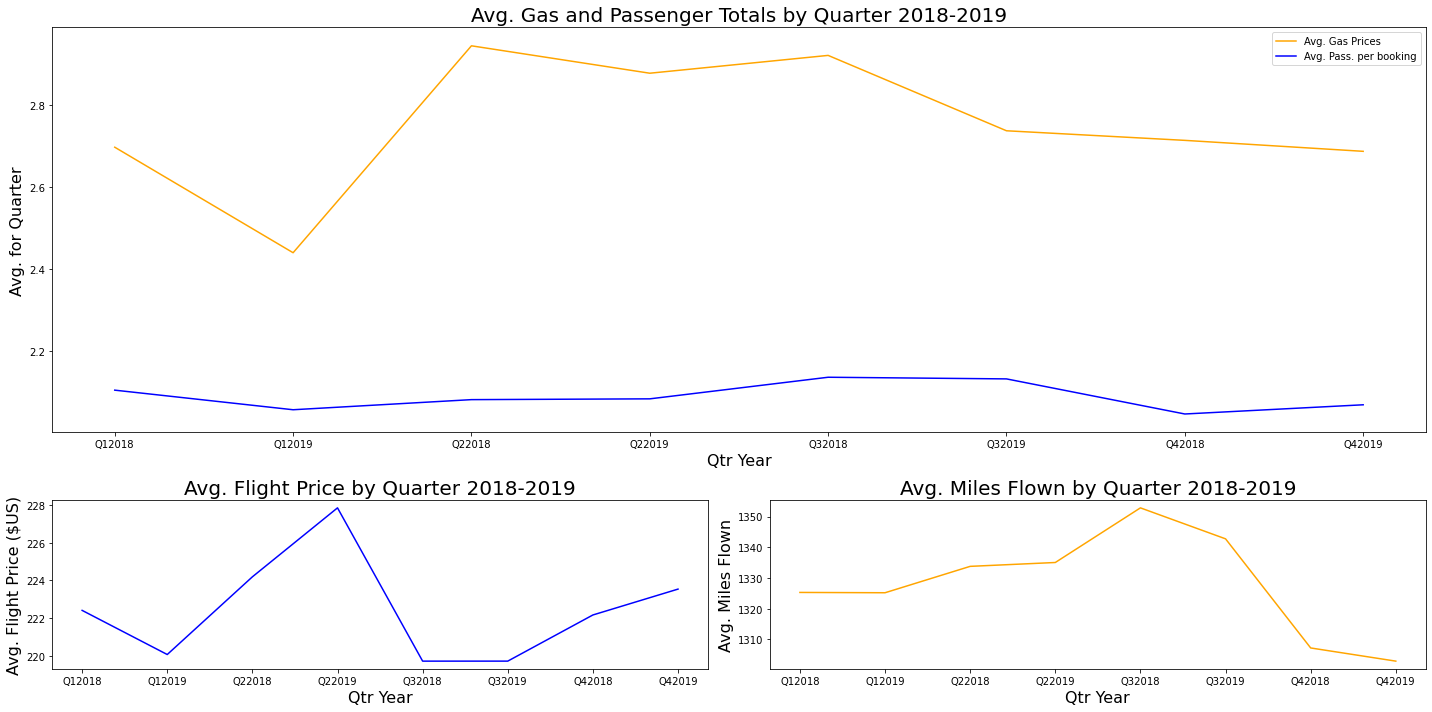

In [83]:
#Create a subplot

plt.figure(figsize=(20,10))
gridspec.GridSpec(3,2)

#Average Gas and Passenger volume over the years
plt.subplot2grid((3,2), (0,0), colspan=2, rowspan=2)
plt.plot(flight_vol['QTR_YEAR'], avg['AVG_GAS_PRICES'], label='Avg. Gas Prices', color='orange')
plt.plot(flight_vol['QTR_YEAR'], avg['AVG_PASSENGERS'], label='Avg. Pass. per booking', color='blue')
plt.xlabel('Qtr Year', size=16)
plt.ylabel('Avg. for Quarter', size=16)
plt.title("Avg. Gas and Passenger Totals by Quarter 2018-2019", size=20)
plt.legend()

#Average price over the years
plt.subplot2grid((3,2), (2,0))
plt.plot(avg['QTR_YEAR'], avg['AVG_FLIGHT_PRICE'], label='Avg. Flight Price', color='blue')
plt.xlabel('Qtr Year', size=16)
plt.ylabel('Avg. Flight Price ($US)', size=16)
plt.title("Avg. Flight Price by Quarter 2018-2019", size=20)


#Average distance over the years

plt.subplot2grid((3,2), (2,1))
plt.plot(avg['QTR_YEAR'], avg['AVG_DISTANCE'], label='Avg. Miles Flown', color='orange')
plt.xlabel('Qtr Year', size=16)
plt.ylabel('Avg. Miles Flown', size=16)
plt.title("Avg. Miles Flown by Quarter 2018-2019", size=20)


plt.tight_layout() 
plt.show()

#### Average Variables Correlation Heatmap

The next data frame was created to see how correlated the variables are to one another. The heatmap indicates that most data points have a moderate to strong correlation except for `AVG_DISTANCE` and `AVG_PASSENGER`, consistent with the above observations. These correlations are much more favourable than the previous heatmap and validate the use of the variables within the analysis.

In [85]:
# Correlation between averages variables

avg_corr = pd.DataFrame(avg.corr())
avg_corr

,AVG_FLIGHT_PRICE,AVG_PASSENGERS,AVG_DISTANCE,AVG_GAS_PRICES
AVG_FLIGHT_PRICE,1.000000,-0.347392,-0.227570,0.400941
AVG_PASSENGERS,-0.347392,1.000000,0.808615,0.456202
AVG_DISTANCE,-0.227570,0.808615,1.000000,0.487114
AVG_GAS_PRICES,0.400941,0.456202,0.487114,1.000000


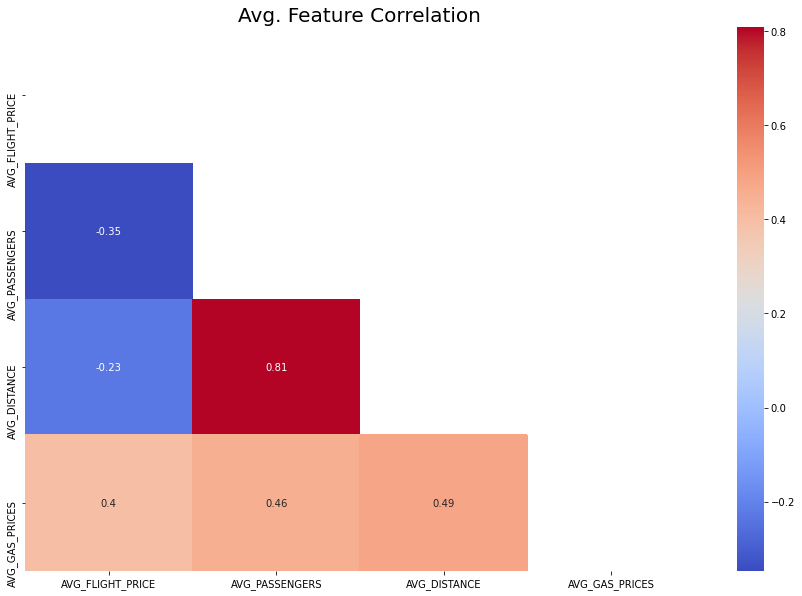

In [89]:
# Correlation of the averages in a heatmap

plt.figure(figsize=(15,10))
matrix = np.triu(avg.corr())
sns.heatmap(avg.corr(), annot=True, mask=matrix, cmap='coolwarm')
plt.title('Avg. Feature Correlation', size=20)
plt.show()

### Convert Categorical Data to Numerical

With a better understanding of the data patterns, it's now safe to move forward with the last preprocessing step, turning the categorical data with `QTR_YEAR`, `DEST`, `DEST_STATE_NM`, `ORIGIN`,  and `ORIGIN_STATE_NM` into numerical data. This will be done by using the `get_dummies`, `.head()` will be used after to confirm the update was made.

In [90]:
#Encode the categorical data using dummies

cat_df = pd.get_dummies(flight_ny_df[['QTR_YEAR','DEST', 'DEST_STATE_NM', 'ORIGIN', 'ORIGIN_STATE_NM']])
cat_df.head().T

,0,1,2,3,4
QTR_YEAR_Q12018,0,0,0,0,0
QTR_YEAR_Q12019,1,1,1,1,1
QTR_YEAR_Q22018,0,0,0,0,0
QTR_YEAR_Q22019,0,0,0,0,0
QTR_YEAR_Q32018,0,0,0,0,0
...,...,...,...,...,...
DEST_STATE_NM_West Virginia,0,0,0,0,0
DEST_STATE_NM_Wisconsin,0,0,0,0,0
DEST_STATE_NM_Wyoming,0,0,0,0,0
ORIGIN_JFK,1,1,1,1,1


### Creation of `flight_ny_mod_df`

The newly encoded data will be added to the other data frame now.

In [91]:
#Append the dummy variable to the data frame

flight_ny_mod_df = pd.concat([flight_ny_df,cat_df], axis=1)
flight_ny_mod_df.shape
flight_ny_mod_df.head().T

,0,1,2,3,4
AVG_FLIGHT_PRICE,208.1,5.5,88,98,98
QTR_YEAR,Q12019,Q12019,Q12019,Q12019,Q12019
PASSENGERS,1,1,1,1,1
MARKET_FARE,208.1,5.5,88,98,98
MARKET_DISTANCE,288,288,288,288,288
...,...,...,...,...,...
DEST_STATE_NM_West Virginia,0,0,0,0,0
DEST_STATE_NM_Wisconsin,0,0,0,0,0
DEST_STATE_NM_Wyoming,0,0,0,0,0
ORIGIN_JFK,1,1,1,1,1


#### Categorical data dropped

The categorical columns will now be dropped since they are hot encoded now.

In [92]:
#drop the colums that were hot encoded

flight_ny_mod_df = flight_ny_mod_df.drop(['QTR_YEAR', 'MARKET_FARE', 'DEST', 'DEST_STATE_NM', 'ORIGIN', 'ORIGIN_STATE_NM'], axis=1)
flight_ny_mod_df.head()

,AVG_FLIGHT_PRICE,PASSENGERS,MARKET_DISTANCE,AVG_GAS_PRICES,QTR_YEAR_Q12018,QTR_YEAR_Q12019,QTR_YEAR_Q22018,QTR_YEAR_Q22019,QTR_YEAR_Q32018,QTR_YEAR_Q32019,...,DEST_STATE_NM_U.S. Virgin Islands,DEST_STATE_NM_Utah,DEST_STATE_NM_Vermont,DEST_STATE_NM_Virginia,DEST_STATE_NM_Washington,DEST_STATE_NM_West Virginia,DEST_STATE_NM_Wisconsin,DEST_STATE_NM_Wyoming,ORIGIN_JFK,ORIGIN_STATE_NM_New York
0,208.1,1,288,2.44,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
1,5.5,1,288,2.44,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
2,88.0,1,288,2.44,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
3,98.0,1,288,2.44,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
4,98.0,1,288,2.44,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1


# Modelling

## Round 1: Based Models

The data is now ready to be modelled. The dependant and independent variables for the data set needs to be defined first. The target variable **( 𝑦 )** is **`AVG_FLIGHT_PRICE`**; this will be isolated and removed from `flight_ny_mod_df` to create the  **( 𝑋 )** feature table.  Twenty percent of the data set will be used to create the test data and a random_state leveraged to maintain similar results with each iteration of the model run. A function was created to support running models. This function will fit the data and calculate model performance using **R-squared (R<sup>2</sup>), Mean Square Error (MSE), Root Mean Square Error (RMSE), and Mean Absolute Error (MAE)**. These metrics are all statistical measurements appropriate for using regression models to measure the difference between the test variable and predicted values.  R-Squared provides a measurement that tells the percentage of the dependant variable explained by the independent variable. While RMSE, MSE and MAP look and the variance in the predicted and test dependant variable and formulate an error value. The objective of RMSE, MSE and MAP is to minimize the value of the errors. R-squared will be referred to most when analysing performance. The function will also include a distribution plot that will visualize the delta between the predicted values and the test data (a.k.a - error). Since the defined dependant variable is continuous, supervised regression machine learning models may be used. Due to the data size, the models will first be run using the default hyperparameters to identify the best performing model then **Randomized Grid Search** to optimize performance.  Through research, the following models have been identified to be effective in predicting flight prices: 
- Linear Regression
- Decision Tree Regressor
- Random Forest Regressor
- Gradient Boosting Regressor
- AdaBoost Regressor


In [93]:
# Saving features to X 
X = flight_ny_mod_df.drop(["AVG_FLIGHT_PRICE"], axis=1)

# Saving target to y 
y = flight_ny_mod_df['AVG_FLIGHT_PRICE']

In [94]:
# Create a train and test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=1)

### Variables Defined

In [95]:
# size of variable data frames

print(f'The shape of the X_train data frame is now {X_train.shape}.')
print(f'The shape of the y_train data frame is now {y_train.shape}.')
print(f'The shape of the X_test data frame is now {X_test.shape}.')
print(f'The shape of the y_test data frame is now {y_test.shape}.')

The shape of the X_train data frame is now (648480, 318).
The shape of the y_train data frame is now (648480,).
The shape of the X_test data frame is now (162121, 318).
The shape of the y_test data frame is now (162121,).


In [96]:
#Created a function to evaluate the base performance of the models

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def predict(ml_model):
    print('Model: {}'.format(ml_model))
    model= ml_model.fit(X_train, y_train)
    print('Training r2:', '{0:0.2f}'.format(model.score(X_train, y_train)))
    predict = model.predict(X_test)
    print('\n')
    r2score=r2_score(y_test,predict) 
    print('Test r2:','{0:0.2f}'.format(r2score))
          
    print('MSE:','{0:0.2f}'.format(mean_squared_error(y_test, predict)))
    print('RMSE:','{0:0.2f}'.format(mean_squared_error(y_test, predict, squared=False)))
    print('MAE:','{0:0.2f}'.format(mean_absolute_error(y_test, predict)))
                                                                                   
    sns.displot(y_test-predict)      


### Linear Regression Model

Model: LinearRegression()
Training r2: 0.09


Test r2: 0.11
MSE: 86170.58
RMSE: 293.55
MAE: 167.37


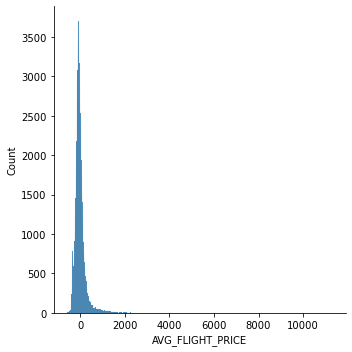

In [134]:
#Run the model 

predict(LinearRegression())

### Decision Tree Regressor Model

Model: DecisionTreeRegressor()
Training r2: 0.27


Test r2: 0.28
MSE: 69865.98
RMSE: 264.32
MAE: 131.59


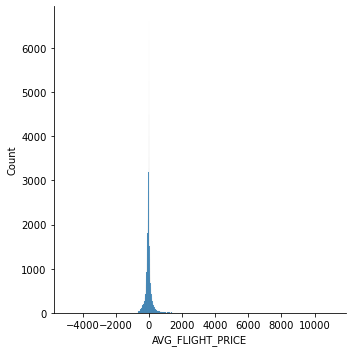

In [135]:
#Run the model

predict(DecisionTreeRegressor())

### Random Forest Regressor Model

Model: RandomForestRegressor()
Training r2: 0.27


Test r2: 0.29
MSE: 68851.25
RMSE: 262.40
MAE: 130.92


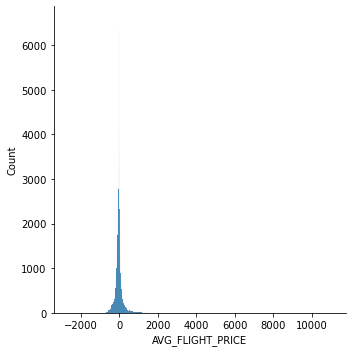

In [136]:
#Run the model

predict(RandomForestRegressor())

### Gradient Boosting Regressor Model

Model: GradientBoostingRegressor()
Training r2: 0.20


Test r2: 0.24
MSE: 73061.31
RMSE: 270.30
MAE: 148.03


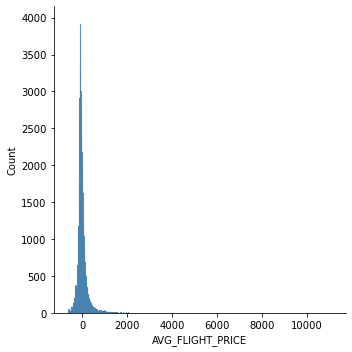

In [137]:
#Run the model

predict(GradientBoostingRegressor())

Model: AdaBoostRegressor()
Training r2: -13.79


Test r2: -17.13
MSE: 1751146.91
RMSE: 1323.31
MAE: 226.95


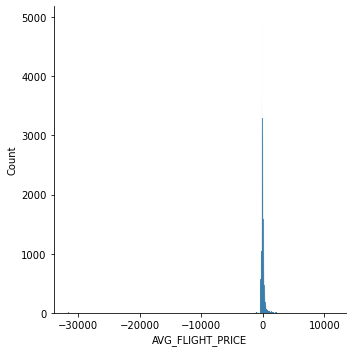

In [138]:
#Run the model

predict(AdaBoostRegressor())

### Model Evaluation:

Below is a summary of the models' performance. Overall the **Random Forrest Regressor** is the best performing model with minimal overfitting. The models first included 2020 data; however, it was removed to improve model performance as 2020 was an anomaly due to COVID-19. By removing 2020, all models increased by **+7%**; however, performance is still lower than expected, and the models also took several hours to run. **Randomized Grid Search** will be run to optimize the **Random Forest Regressor** model performance as a next step. Then **Principle Component Analysis (PCA)** applied  to reduce the dimensionality of the data.  A deep dive will be performed on the dependant variable to identify areas of opportunity to improve model performance. 


<img src="files/Images/model__1.png">


### Randomized Grid Search

A **Pipeline** has been created to perform the scaling, dimensionality reduction and hyperparameter fitting within one step. As well as a **Randomized Grid Search** with the below variables. Due to the several hours required to compute this search, `cv` = 2, and there will be 10 `n_iter` for a total of 20 fittings.

<img src="files/Images/gridsearch_1.png"> 

In [139]:
# Placeholders for the series of steps we're using

pipe_estimators = [('scaling', StandardScaler()),
                   ('dim_reduction', PCA()),
                   ('model', RandomForestRegressor())]

mod_pipe = Pipeline(pipe_estimators)

#### Randomized Grid Search Fittings

In [140]:
# create a grid search to optimize the hyperparameters within the model

rf_grid =  {'model': [RandomForestRegressor()],
            'scaling': [None, StandardScaler()],
            'dim_reduction__n_components': [5,6,7],
            'model__bootstrap': [True, False],
            'model__max_depth': [10, 20,  50, 100, None],
            'model__max_features': ['auto', 'sqrt'],
            'model__min_samples_leaf': [1, 2, 4],
            'model__min_samples_split': [2, 5, 10],
            'model__n_estimators': [200, 400, 600, 800, 1000, 2000]}



model_gridsearch = RandomizedSearchCV(mod_pipe, param_distributions=rf_grid, cv=2, verbose=2, n_iter=10, return_train_score=True)
model_gridsearch.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END dim_reduction__n_components=5, model=RandomForestRegressor(), model__bootstrap=False, model__max_depth=50, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=200, scaling=None; total time= 1.5min
[CV] END dim_reduction__n_components=5, model=RandomForestRegressor(), model__bootstrap=False, model__max_depth=50, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=200, scaling=None; total time= 1.5min
[CV] END dim_reduction__n_components=7, model=RandomForestRegressor(), model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=600, scaling=None; total time= 3.8min
[CV] END dim_reduction__n_components=7, model=RandomForestRegressor(), model__bootstrap=False, model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model

RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                             ('dim_reduction', PCA()),
                                             ('model',
                                              RandomForestRegressor())]),
                   param_distributions={'dim_reduction__n_components': [5, 6,
                                                                        7],
                                        'model': [RandomForestRegressor(max_depth=10,
                                                                        max_features='sqrt',
                                                                        min_samples_leaf=4,
                                                                        min_samples_split=5,
                                                                        n_estimators=200)],
                                        'model__bootstrap': [True, False],
              

#### Best Hyperparameters

In [141]:
#The paprameters that gave the highest score

model_gridsearch.best_params_

{'scaling': None,
 'model__n_estimators': 200,
 'model__min_samples_split': 5,
 'model__min_samples_leaf': 4,
 'model__max_features': 'sqrt',
 'model__max_depth': 10,
 'model__bootstrap': True,
 'model': RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=5, n_estimators=200),
 'dim_reduction__n_components': 5}

#### Model R<sup>2</sup> with Optimized Parameters

The hyperparameter optimization did not improve the R<sup>2</sup>, performance dropped to 8% from 32%. As a result, the base model performance will be used insted. Next PCA will be used to reduce the dimensionality of the data to help with model run-time performance.

In [142]:
#The score based on the best parameters

model_gridsearch.best_score_

0.07877831172878508

## Demonsionality Reduction

As the data contains different units of measures, a **Standard Scaler** will be applied to the data to ensure data variances are proportional to the overall data with a `n_component` threshold of 95%. Following **PCA**, the columns were reduced from 318 to 246 (-23%). The models will now be re-run to see the variance.

In [143]:
# Scaling the data sets

# Fit scaler
scaler = StandardScaler()
scaled = scaler.fit(X_train)

# Transform the data sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [144]:
# Instantiate and fit to scaled training data
flight_pca = PCA(n_components=0.95).fit(X_train)

# Transform train and test sets
X_train = flight_pca.transform(X_train)
X_test = flight_pca.transform(X_test)

In [145]:
#Check the size of the data fram due to PCA

print(f'PCA Transformed Train Data Frame size: {X_train.shape}')
print(f'PCA Transformed Test Data Frame size: {X_test.shape}')

PCA Transformed Train Data Frame size: (648480, 234)
PCA Transformed Test Data Frame size: (162121, 234)


## Round 2: Modelling with PCA

Model: LinearRegression()
Training r2: 0.09


Test r2: 0.11
MSE: 86191.57
RMSE: 293.58
MAE: 167.39


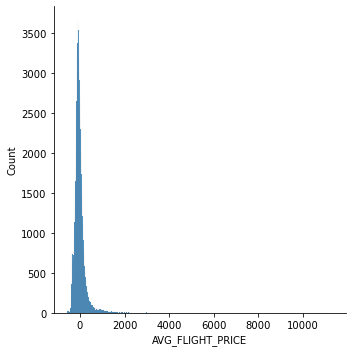

In [146]:
#Run the model 


predict(LinearRegression())


Model: DecisionTreeRegressor()
Training r2: 0.27


Test r2: 0.28
MSE: 69708.10
RMSE: 264.02
MAE: 131.52


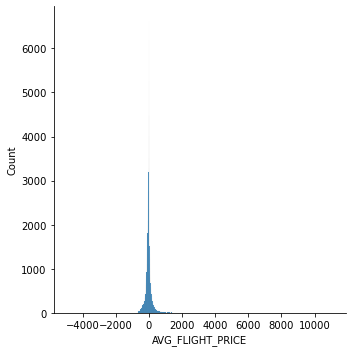

In [147]:
#Run the model

predict(DecisionTreeRegressor())

Model: RandomForestRegressor()
Training r2: 0.27


Test r2: 0.29
MSE: 68882.42
RMSE: 262.45
MAE: 130.94


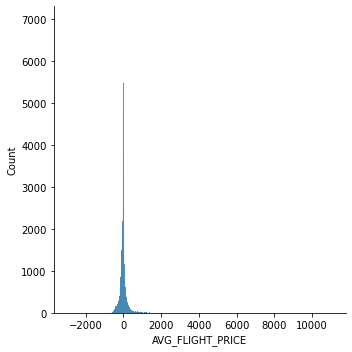

In [148]:
#Run the model

predict(RandomForestRegressor())

Model: GradientBoostingRegressor()
Training r2: 0.20


Test r2: 0.23
MSE: 74074.15
RMSE: 272.17
MAE: 150.70


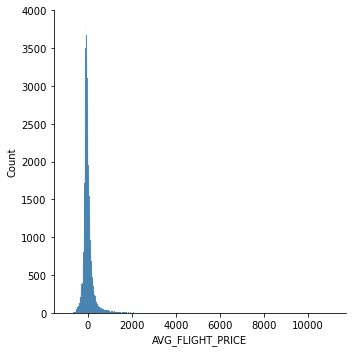

In [149]:
#Run the model

predict(GradientBoostingRegressor())

Model: AdaBoostRegressor()
Training r2: -13.30


Test r2: -16.59
MSE: 1698920.76
RMSE: 1303.43
MAE: 222.34


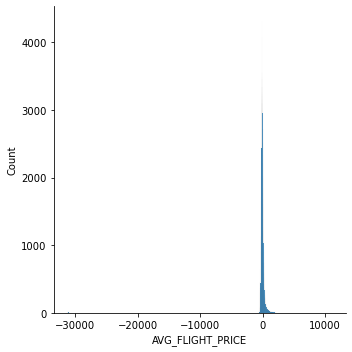

In [150]:
#Run the model

predict(AdaBoostRegressor())

### Model Evaluation:

The  **Random Forrest Regressor** is still the best performing model with minimal overfitting. There's been no change to the  **R<sup>2</sup>** performance of the top models and minor error increases to MSE. As a result, PCA will be used for the model going forward. The data will now be re-looked at to identify outliers in the `AVG_FLIGHT_PRICE` column.

<img src="files/Images/model__2.png">

# Deep Dive into Pricing

A function has been created to visualize the outliers within the data using a distribution and box plot. There appears to be a very narrow range for the data with many outliers ranging from 550 - 100K. This extensive range is undoubtedly impacting model performance. Reasons for these outliers may be due to different seat classes (i.e., first-class) our privately chartered flights. The `high_price_df` has been created to determine the number of outliers within the data. In total, there are 65,163 outliers within the data set. To remove these outliers will result in an 8% decrease to the data frame. This data loss is acceptable given model performance and will be actioned. 

In [100]:
#Create a function to deep dive into outliers

def plot(data,col):
    
    '''
        This function displays the distrution 
        and box plot graph of the data fram and
        column indicated
    '''
    fig,(ax1,ax2)=plt.subplots(2,1)
    sns.distplot(data[col],ax=ax1)
    sns.boxplot(data[col],ax=ax2)

### `AVG_FLIGHT_PRICE` Visualizations

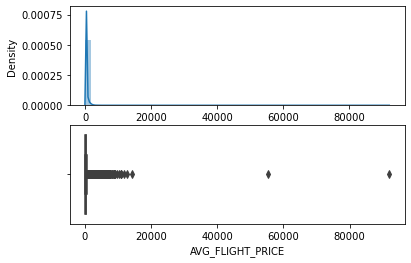

In [101]:
#Plot the Avg. Fare

plot(flight_ny_df,'AVG_FLIGHT_PRICE')




### `AVG_FLIGHT_PRICE` $550 + Data Frame

In [151]:
# Isolate the Avg_Flight price above $550

high_price_df = flight_ny_df[(flight_ny_df['AVG_FLIGHT_PRICE'] > 550)]
                                         
high_price_df

,AVG_FLIGHT_PRICE,QTR_YEAR,PASSENGERS,MARKET_FARE,MARKET_DISTANCE,AVG_GAS_PRICES,ORIGIN,ORIGIN_STATE_NM,DEST,DEST_STATE_NM
47,612.00,Q12019,1,612.00,288,2.440000,JFK,New York,RIC,Virginia
48,679.00,Q12019,1,679.00,288,2.440000,JFK,New York,RIC,Virginia
190,703.00,Q12019,1,703.00,288,2.440000,JFK,New York,RIC,Virginia
1124,577.00,Q42019,1,577.00,288,2.686667,JFK,New York,RIC,Virginia
1125,619.00,Q42019,1,619.00,288,2.686667,JFK,New York,RIC,Virginia
...,...,...,...,...,...,...,...,...,...,...
810257,592.35,Q12018,1,592.35,248,2.696667,JFK,New York,HYA,Massachusetts
810346,618.62,Q32018,1,618.62,230,2.920000,JFK,New York,HYA,Massachusetts
810479,552.00,Q32018,1,552.00,196,2.920000,JFK,New York,HYA,Massachusetts
810480,581.00,Q32018,1,581.00,196,2.920000,JFK,New York,HYA,Massachusetts


### Remove Outliers

The outliers will be dropped and the models re-run to see the change in performance.

#### `red_flight_df2 ` Outliers Removed

In [152]:
#Drop price points above $550
red_flight_df2 = flight_df2.drop(flight_df2[flight_df2.AVG_FLIGHT_PRICE >=550].index)
red_flight_df2 

,ORIGIN,ORIGIN_STATE_NM,DEST,PASSENGERS,MARKET_FARE,MARKET_DISTANCE,DEST_STATE_NM,QTR_YEAR,AVG_FLIGHT_PRICE,AVG_GAS_PRICES,AVG_FLIGHT_VOL
0,CLT,North Carolina,RIC,1,352.5,257,NaN,Q12019,352.5,2.440000,7698
1,CLT,North Carolina,RIC,1,353.0,257,NaN,Q12019,353.0,2.440000,7698
2,CLT,North Carolina,RIC,1,353.5,257,NaN,Q12019,353.5,2.440000,7698
3,CLT,North Carolina,RIC,1,353.5,257,NaN,Q12019,353.5,2.440000,7698
4,CLT,North Carolina,RIC,1,356.5,257,NaN,Q12019,356.5,2.440000,7698
...,...,...,...,...,...,...,...,...,...,...,...
55061226,PIE,Florida,YNG,1,78.0,927,Ohio,Q12018,78.0,2.696667,1840
55061227,PIE,Florida,YNG,2,79.0,927,Ohio,Q12018,39.5,2.696667,1840
55061228,PIE,Florida,YNG,1,86.0,927,Ohio,Q12018,86.0,2.696667,1840
55061229,PIE,Florida,YNG,1,95.0,927,Ohio,Q12018,95.0,2.696667,1840


#### `red_flight_df3` Outliers Removed

In [153]:
#Drop price points above $550
red_flight_df3 = flight_df3.drop(flight_df3[flight_df3.AVG_FLIGHT_PRICE >=550].index)
red_flight_df3  

,AVG_FLIGHT_PRICE,QTR_YEAR,PASSENGERS,MARKET_FARE,MARKET_DISTANCE,AVG_GAS_PRICES,ORIGIN,ORIGIN_STATE_NM,DEST,DEST_STATE_NM
0,352.5,Q12019,1,352.5,257,2.440000,CLT,North Carolina,RIC,Virginia
1,353.0,Q12019,1,353.0,257,2.440000,CLT,North Carolina,RIC,Virginia
2,353.5,Q12019,1,353.5,257,2.440000,CLT,North Carolina,RIC,Virginia
3,353.5,Q12019,1,353.5,257,2.440000,CLT,North Carolina,RIC,Virginia
4,356.5,Q12019,1,356.5,257,2.440000,CLT,North Carolina,RIC,Virginia
...,...,...,...,...,...,...,...,...,...,...
55061226,78.0,Q12018,1,78.0,927,2.696667,PIE,Florida,YNG,Ohio
55061227,39.5,Q12018,2,79.0,927,2.696667,PIE,Florida,YNG,Ohio
55061228,86.0,Q12018,1,86.0,927,2.696667,PIE,Florida,YNG,Ohio
55061229,95.0,Q12018,1,95.0,927,2.696667,PIE,Florida,YNG,Ohio


#### `red_flight_ny_df` Outliers Removed

In [154]:
#Drop price points above $700
red_flight_ny_df = flight_ny_df.drop(flight_ny_df[flight_ny_df.AVG_FLIGHT_PRICE >=550].index)
red_flight_ny_df 

,AVG_FLIGHT_PRICE,QTR_YEAR,PASSENGERS,MARKET_FARE,MARKET_DISTANCE,AVG_GAS_PRICES,ORIGIN,ORIGIN_STATE_NM,DEST,DEST_STATE_NM
0,208.10,Q12019,1,208.10,288,2.440000,JFK,New York,RIC,Virginia
1,5.50,Q12019,1,5.50,288,2.440000,JFK,New York,RIC,Virginia
2,88.00,Q12019,1,88.00,288,2.440000,JFK,New York,RIC,Virginia
3,98.00,Q12019,1,98.00,288,2.440000,JFK,New York,RIC,Virginia
4,98.00,Q12019,1,98.00,288,2.440000,JFK,New York,RIC,Virginia
...,...,...,...,...,...,...,...,...,...,...
810595,474.50,Q32018,1,474.50,196,2.920000,JFK,New York,HYA,Massachusetts
810596,176.88,Q32018,1,176.88,196,2.920000,JFK,New York,HYA,Massachusetts
810597,325.60,Q32018,1,325.60,196,2.920000,JFK,New York,HYA,Massachusetts
810598,225.50,Q42018,1,225.50,248,2.713333,JFK,New York,HYA,Massachusetts


### `AVG_FLIGHT_PRICE` Outliers Removed Visualization

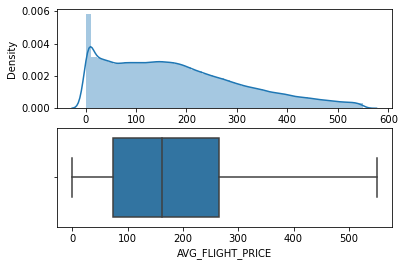

In [106]:
#Check to see that the update has been made

plot(red_flight_ny_df,'AVG_FLIGHT_PRICE')

In [110]:
print(f'Outliers removed Flight NY deminsions {red_flight_ny_df.shape}')

Outliers removed Flight NY deminsions (745438, 10)


# Outlier Visualization

A few key visualizations will be re-created, given the change to the data set to see if any significant changes have occurred. The visuals patterns are consistent with the previous visuals, with slight increases to the correlation of the variables. Therefore no additional commentary was added below. 

### Variable Correlation Heatmap

The following data frame was created to see how correlated the variables are to one another. A heatmap was then used to depict the information visually. 

In [111]:
# Correlation between independent variables

red_flight_ny_df_corr = pd.DataFrame(red_flight_ny_df.corr())
red_flight_ny_df_corr

,AVG_FLIGHT_PRICE,PASSENGERS,MARKET_FARE,MARKET_DISTANCE,AVG_GAS_PRICES
AVG_FLIGHT_PRICE,1.000000,-0.274156,0.695664,0.215842,0.001313
PASSENGERS,-0.274156,1.000000,-0.064105,0.019101,0.001886
MARKET_FARE,0.695664,-0.064105,1.000000,0.299905,0.008681
MARKET_DISTANCE,0.215842,0.019101,0.299905,1.000000,0.003346
AVG_GAS_PRICES,0.001313,0.001886,0.008681,0.003346,1.000000


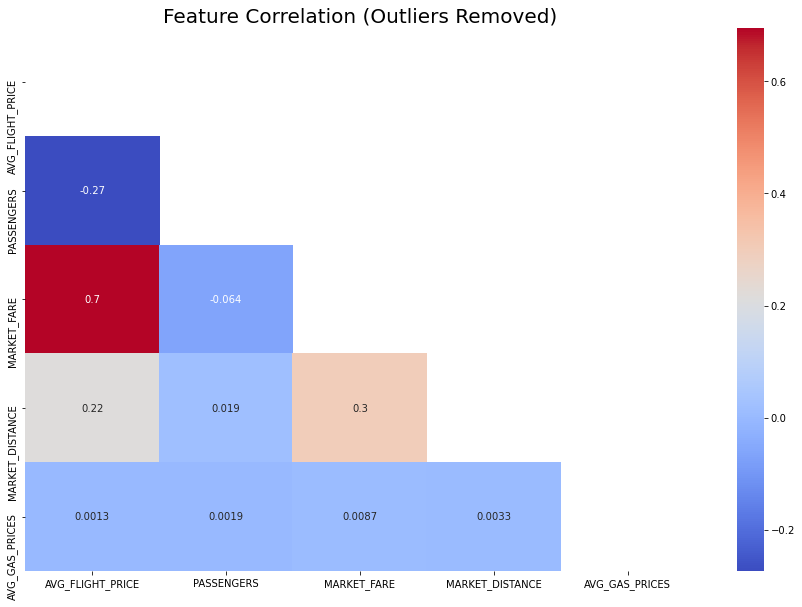

In [112]:
# Correlation of the variables in a heatmap

plt.figure(figsize=(15,10))
matrix = np.triu(red_flight_ny_df.corr())
sns.heatmap(red_flight_ny_df.corr(), annot=True, mask=matrix, cmap='coolwarm')
plt.title('Feature Correlation (Outliers Removed)', size=20)
plt.show()

### Flight Volume by Quarter

The following data frame is created to develop visualizations that will show the total volume by quarter. 

In [113]:
#Create a data frame to plot the overall volume

red_flight_vol = red_flight_ny_df.groupby('QTR_YEAR').sum().reset_index()
red_flight_vol = red_flight_vol.drop(['AVG_FLIGHT_PRICE', 'AVG_GAS_PRICES'], axis=1)
red_flight_vol.to_csv('red_flight_vol.csv')
red_flight_vol

,QTR_YEAR,PASSENGERS,MARKET_FARE,MARKET_DISTANCE
0,Q12018,224250,18729004.51,128499158
1,Q12019,243265,19046088.36,134290207
2,Q22018,265583,21766634.27,146061520
3,Q22019,281570,23449136.35,157979629
4,Q32018,273447,22149299.86,154664368
5,Q32019,275054,22232195.02,150339201
6,Q42018,275458,24297619.38,161767493
7,Q42019,268863,24741838.01,158043562


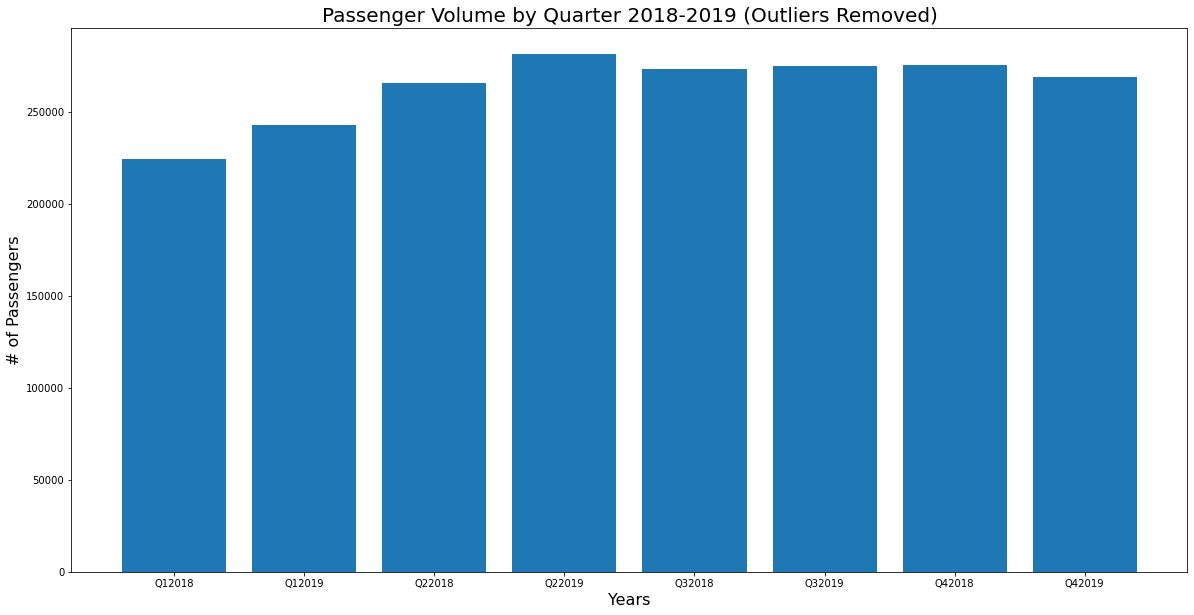

In [114]:
#Plot the passenger volume over the years


x_v = red_flight_vol['QTR_YEAR']
y_v = red_flight_vol['PASSENGERS']


plt.figure(figsize=(20,10))
plt.bar(x_v, y_v)
plt.xlabel('Years', size=16)
plt.ylabel('# of Passengers', size=16)
plt.title('Passenger Volume by Quarter 2018-2019 (Outliers Removed)', size=20)
plt.show()

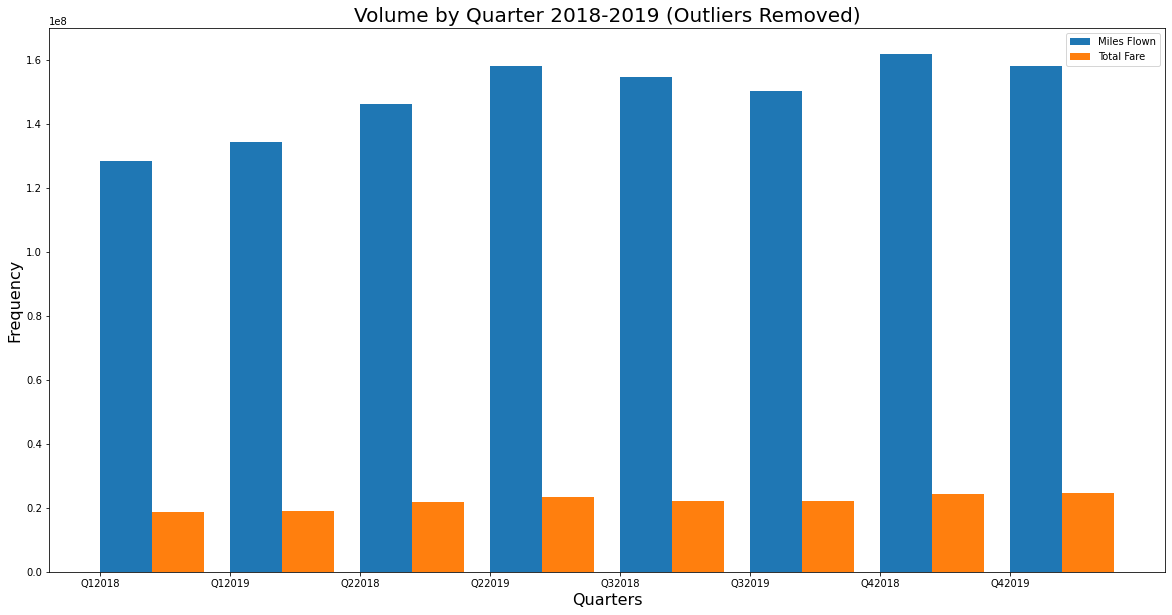

In [115]:
# Create graph of miles and market fare volume

fig = plt.subplots(figsize =(20, 10))
 

# set variables for graph
X = red_flight_vol['QTR_YEAR']
md = red_flight_vol['MARKET_DISTANCE'] 
mf = red_flight_vol['MARKET_FARE'] 
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis + 0.2, md, 0.4, label = 'Miles Flown')
plt.bar(X_axis + 0.6, mf, 0.4, label = 'Total Fare')
  
plt.xticks(X_axis, X)
plt.xlabel("Quarters", size=16)
plt.ylabel("Frequency", size=16)
plt.title("Volume by Quarter 2018-2019 (Outliers Removed)", size=20)
plt.legend()
plt.show()


### Top 20 Destination

The next data frame is created to develop visualizations that will show the top destinations based on bookings within the data set. The list of top destinations is similar to the overall highest volume airports in America. Atlanta airport is deemed the busiest airport in America; however, it's only fourth within this list. Most likely due to the large amount of business travel that occurs for LAX, ORD and SFO.

In [116]:
#Created a data frame to see the top 20 destinations

red_x_dest = pd.DataFrame(red_flight_df2['DEST'].value_counts()[:20].sort_values(ascending=False))
red_x_dest.to_csv('red_x_dest.csv')
red_x_dest

,DEST
LAX,1641510
ORD,1406830
DEN,1353186
ATL,1297751
SEA,1258438
SFO,1199487
MCO,1181976
BOS,1174620
LAS,1144672
LGA,1072394


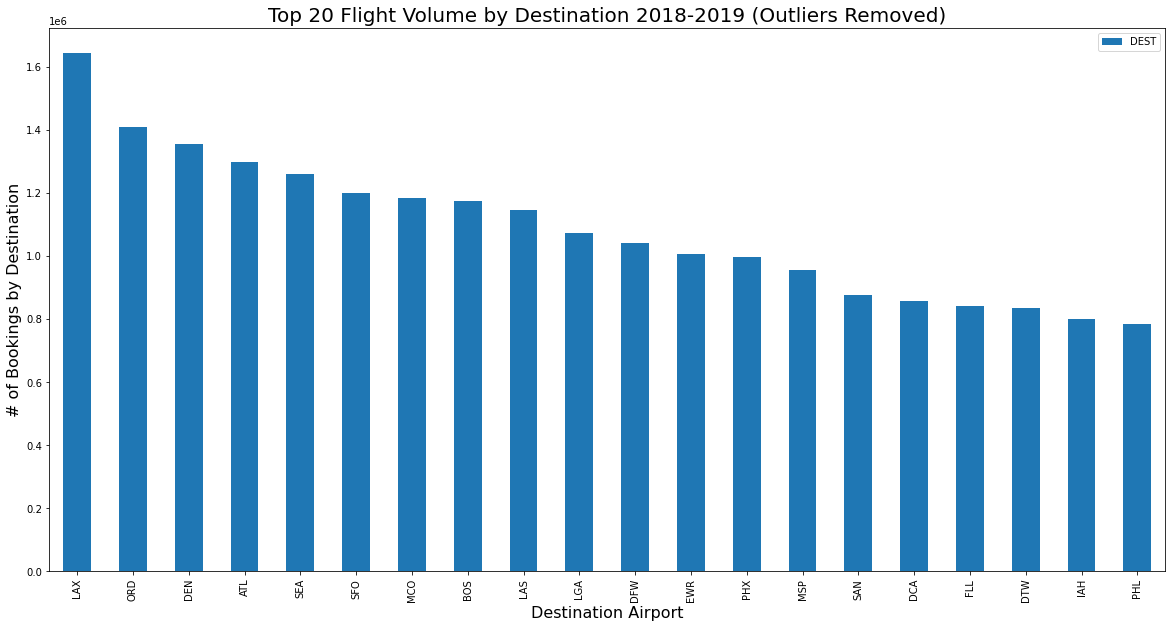

In [117]:
#Top 20 destination airports

ax = red_x_dest.plot.bar(y='DEST', rot=90, figsize=(20,10))
plt.xlabel('Destination Airport', size=16)
plt.ylabel('# of Bookings by Destination', size=16)
plt.title('Top 20 Flight Volume by Destination 2018-2019 (Outliers Removed)', size=20)
plt.show()

### Flight Volume by State


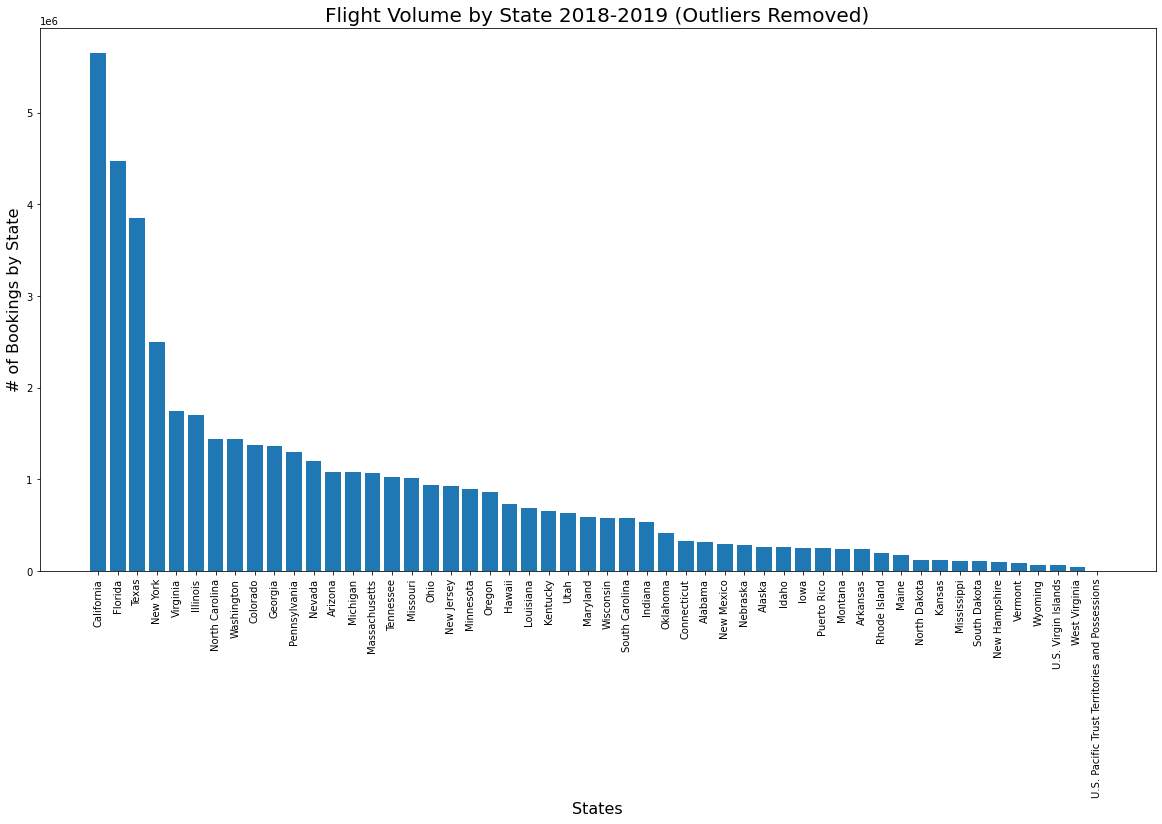

In [118]:
#Plot the frequency by state over the years

plt.figure(figsize=(20,10))
plt.bar(red_flight_df2['DEST_STATE_NM'].value_counts().index,
        red_flight_df2['DEST_STATE_NM'].value_counts().values)
plt.xticks(rotation=90)
plt.xlabel('States', size=16)
plt.ylabel('# of Bookings by State', size=16)
plt.title('Flight Volume by State 2018-2019 (Outliers Removed)', size=20)
plt.show()

### Averages Deep Dive

Since the dependent variable is based on averages, the below deep drive looks into the data to see any relevant patterns based on the averages for each quarter.  

#### Averages Volume by Quarter

The following data frame is created to develop visualizations that will show the average volume by quarter.

In [119]:
#Created a data frame to visualize the averages throughout the quarters

red_avg = red_flight_df3.groupby('QTR_YEAR').agg(['mean']).reset_index()
red_avg = red_avg.drop(['MARKET_FARE'], axis=1)
red_avg.columns = red_avg.columns.droplevel(1)
red_avg.rename(columns={'PASSENGERS':'AVG_PASSENGERS', 'MARKET_FARE':'AVG_MARKET_FARE', 'MARKET_DISTANCE' : 'AVG_DISTANCE'}, inplace=True)
red_avg

,QTR_YEAR,AVG_FLIGHT_PRICE,AVG_PASSENGERS,AVG_DISTANCE,AVG_GAS_PRICES
0,Q12018,190.891808,2.164252,1283.267921,2.696667
1,Q12019,189.743758,2.111662,1288.159699,2.440000
2,Q22018,194.283390,2.136777,1294.706516,2.943333
3,Q22019,197.991703,2.140715,1295.720543,2.876667
4,Q32018,190.443287,2.191688,1317.168127,2.920000
5,Q32019,193.757427,2.185109,1306.570706,2.736667
6,Q42018,191.588607,2.101004,1266.059724,2.713333
7,Q42019,193.814477,2.124593,1260.740374,2.686667


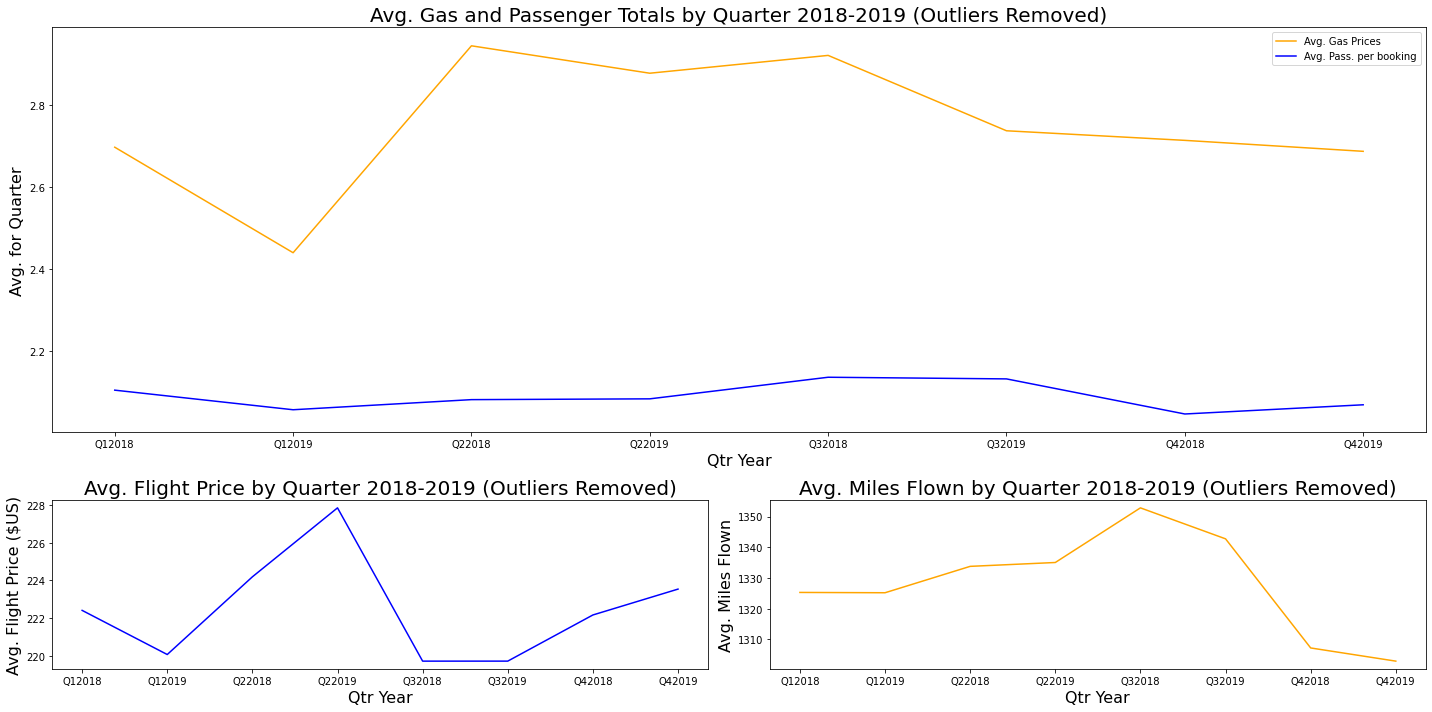

In [121]:
#Create a subplot

plt.figure(figsize=(20,10))
gridspec.GridSpec(3,2)

#Average Gas and Passenger volume over the years
plt.subplot2grid((3,2), (0,0), colspan=2, rowspan=2)
plt.plot(red_flight_vol['QTR_YEAR'], avg['AVG_GAS_PRICES'], label='Avg. Gas Prices', color='orange')
plt.plot(red_flight_vol['QTR_YEAR'], avg['AVG_PASSENGERS'], label='Avg. Pass. per booking', color='blue')
plt.xlabel('Qtr Year', size=16)
plt.ylabel('Avg. for Quarter', size=16)
plt.title("Avg. Gas and Passenger Totals by Quarter 2018-2019 (Outliers Removed)", size=20)
plt.legend()

#Average price over the years
plt.subplot2grid((3,2), (2,0))
plt.plot(red_avg['QTR_YEAR'], avg['AVG_FLIGHT_PRICE'], label='Avg. Flight Price', color='blue')
plt.xlabel('Qtr Year', size=16)
plt.ylabel('Avg. Flight Price ($US)', size=16)
plt.title("Avg. Flight Price by Quarter 2018-2019 (Outliers Removed)", size=20)


#Average distance over the years

plt.subplot2grid((3,2), (2,1))
plt.plot(red_avg['QTR_YEAR'], avg['AVG_DISTANCE'], label='Avg. Miles Flown', color='orange')
plt.xlabel('Qtr Year', size=16)
plt.ylabel('Avg. Miles Flown', size=16)
plt.title("Avg. Miles Flown by Quarter 2018-2019 (Outliers Removed)", size=20)


plt.tight_layout() 
plt.show()

#### Average Correlation

The following data frame is created to develop visualizations that will show the average volume by quarter.

#### Average Variables Correlation Heatmap

In [155]:
# Correlation between averages variables

red_avg_corr = pd.DataFrame(red_avg.corr())
red_avg_corr

,AVG_FLIGHT_PRICE,AVG_PASSENGERS,AVG_DISTANCE,AVG_GAS_PRICES
AVG_FLIGHT_PRICE,1.000000,-0.013177,0.017814,0.505003
AVG_PASSENGERS,-0.013177,1.000000,0.779584,0.461007
AVG_DISTANCE,0.017814,0.779584,1.000000,0.445732
AVG_GAS_PRICES,0.505003,0.461007,0.445732,1.000000


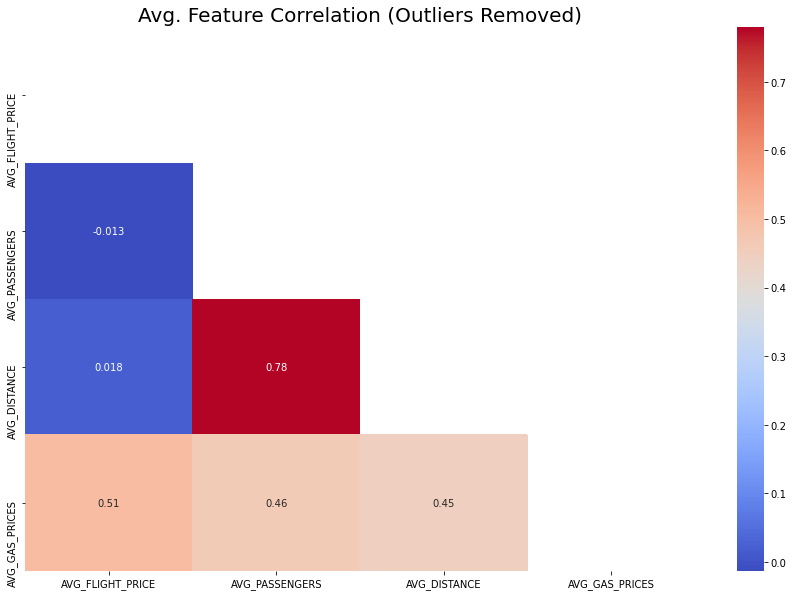

In [156]:
# Correlation of the averages in a heatmap

plt.figure(figsize=(15,10))
matrix = np.triu(red_avg.corr())
sns.heatmap(red_avg.corr(), annot=True, mask=matrix, cmap='coolwarm')
plt.title('Avg. Feature Correlation (Outliers Removed)', size=20)
plt.show()

### Convert Categorical Data to Numerical (Outliers Removed)

In [124]:
#Encode the categorical data using dummies

red_cat_df = pd.get_dummies(red_flight_ny_df[['QTR_YEAR','DEST', 'DEST_STATE_NM', 'ORIGIN', 'ORIGIN_STATE_NM']])
red_cat_df.head().T

,0,1,2,3,4
QTR_YEAR_Q12018,0,0,0,0,0
QTR_YEAR_Q12019,1,1,1,1,1
QTR_YEAR_Q22018,0,0,0,0,0
QTR_YEAR_Q22019,0,0,0,0,0
QTR_YEAR_Q32018,0,0,0,0,0
...,...,...,...,...,...
DEST_STATE_NM_West Virginia,0,0,0,0,0
DEST_STATE_NM_Wisconsin,0,0,0,0,0
DEST_STATE_NM_Wyoming,0,0,0,0,0
ORIGIN_JFK,1,1,1,1,1


In [125]:
#Append the dummy variable to the data frame

red_flight_ny_mod_df = pd.concat([red_flight_ny_df,red_cat_df], axis=1)
red_flight_ny_mod_df.shape
red_flight_ny_mod_df.head().T

,0,1,2,3,4
AVG_FLIGHT_PRICE,208.1,5.5,88,98,98
QTR_YEAR,Q12019,Q12019,Q12019,Q12019,Q12019
PASSENGERS,1,1,1,1,1
MARKET_FARE,208.1,5.5,88,98,98
MARKET_DISTANCE,288,288,288,288,288
...,...,...,...,...,...
DEST_STATE_NM_West Virginia,0,0,0,0,0
DEST_STATE_NM_Wisconsin,0,0,0,0,0
DEST_STATE_NM_Wyoming,0,0,0,0,0
ORIGIN_JFK,1,1,1,1,1


In [126]:
#drop the colums that were hot encoded

red_flight_ny_mod_df = red_flight_ny_mod_df.drop(['QTR_YEAR', 'MARKET_FARE', 'DEST', 'DEST_STATE_NM', 'ORIGIN', 'ORIGIN_STATE_NM'], axis=1)
red_flight_ny_mod_df.head()

,AVG_FLIGHT_PRICE,PASSENGERS,MARKET_DISTANCE,AVG_GAS_PRICES,QTR_YEAR_Q12018,QTR_YEAR_Q12019,QTR_YEAR_Q22018,QTR_YEAR_Q22019,QTR_YEAR_Q32018,QTR_YEAR_Q32019,...,DEST_STATE_NM_U.S. Virgin Islands,DEST_STATE_NM_Utah,DEST_STATE_NM_Vermont,DEST_STATE_NM_Virginia,DEST_STATE_NM_Washington,DEST_STATE_NM_West Virginia,DEST_STATE_NM_Wisconsin,DEST_STATE_NM_Wyoming,ORIGIN_JFK,ORIGIN_STATE_NM_New York
0,208.1,1,288,2.44,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
1,5.5,1,288,2.44,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
2,88.0,1,288,2.44,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
3,98.0,1,288,2.44,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
4,98.0,1,288,2.44,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1


### Defining Variables  (Outliers Removed)

The variables for the modified data frame are defined and split into train and test. 

In [127]:
# Saving original features to X 
X_red = red_flight_ny_mod_df.drop(["AVG_FLIGHT_PRICE"], axis=1)

# Saving target to y 
y_red = red_flight_ny_mod_df['AVG_FLIGHT_PRICE']

In [128]:
# Create a train and test split

from sklearn.model_selection import train_test_split

X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(X_red, y_red,
                                                   test_size=0.2,
                                                   random_state=1)

In [129]:
# size of variable data frames

print(f'The shape of the X_train data frame is now {X_red_train.shape}.')
print(f'The shape of the y_train data frame is now {y_red_train.shape}.')
print(f'The shape of the X_test data frame is now {X_red_test.shape}.')
print(f'The shape of the y_test data frame is now {y_red_test.shape}.')

The shape of the X_train data frame is now (596350, 316).
The shape of the y_train data frame is now (596350,).
The shape of the X_test data frame is now (149088, 316).
The shape of the y_test data frame is now (149088,).


# Demonsionality Reduction (Outliers Removed)

PCA is re-run based on the new data frame. An `n_component` threshold of 95% is used again. Following PCA, the columns were reduced from 316 to 245 (-23%). The models will now be re-run to see the variance.

In [130]:
# Scaling the data sets

# Fit scaler
scaler = StandardScaler()
scaled = scaler.fit(X_red_train)

# Transform the data sets
X_red_train = scaler.transform(X_red_train)
X_red_test = scaler.transform(X_red_test)



In [131]:
# Instantiate and fit to scaled training data
flight_red_pca = PCA(n_components=0.95).fit(X_red_train)

# Transform train and test sets
X_red_train = flight_red_pca.transform(X_red_train)
X_red_test = flight_red_pca.transform(X_red_test)

In [132]:
#Check the size of the data fram due to PCA

print(f'PCA Transformed Data Frame size: {X_red_train.shape}')
print(f'PCA Transformed Data Frame size: {X_red_test.shape}')

PCA Transformed Data Frame size: (596350, 245)
PCA Transformed Data Frame size: (149088, 245)


## Round 3: Modelling (Outliers Removed)

The prediction model is revised to include the new data frame and the models re-run.

In [133]:
#Created a function to evaluate the base performance of the models

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def red_predict(ml_model):
    print('Model: {}'.format(ml_model))
    model= ml_model.fit(X_red_train, y_red_train)
    print('Training r2:', '{0:0.2f}'.format(model.score(X_red_train, y_red_train)))
    red_predict = model.predict(X_red_test)
    print('\n')
    r2score=r2_score(y_red_test,red_predict) 
    print('Test r2:','{0:0.2f}'.format(r2score))
          
    print('MSE:','{0:0.2f}'.format(mean_squared_error(y_red_test, red_predict)))
    print('RMSE:','{0:0.2f}'.format(mean_squared_error(y_red_test, red_predict, squared=False)))
    print('MAE:','{0:0.2f}'.format(mean_absolute_error(y_red_test, red_predict)))

                                                                                   
    sns.displot(y_red_test-red_predict)      


Model: LinearRegression()
Training r2: 0.13


Test r2: 0.12
MSE: 15221.04
RMSE: 123.37
MAE: 98.85


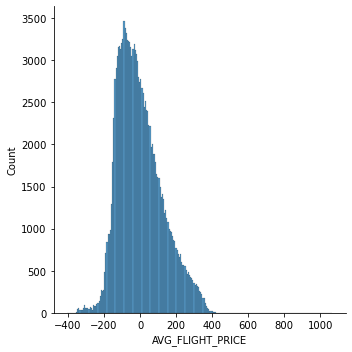

In [75]:
#Run the model 

red_predict(LinearRegression())

Model: DecisionTreeRegressor()
Training r2: 0.51


Test r2: 0.45
MSE: 9608.70
RMSE: 98.02
MAE: 68.71


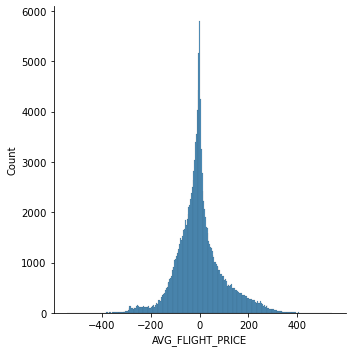

In [76]:
#Run the model

red_predict(DecisionTreeRegressor())

Model: RandomForestRegressor()
Training r2: 0.50


Test r2: 0.46
MSE: 9445.22
RMSE: 97.19
MAE: 68.36


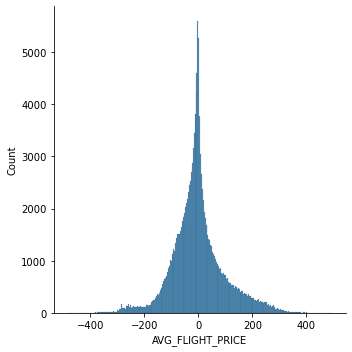

In [77]:
#Run the model

red_predict(RandomForestRegressor())

Model: GradientBoostingRegressor()
Training r2: 0.32


Test r2: 0.32
MSE: 11813.23
RMSE: 108.69
MAE: 84.54


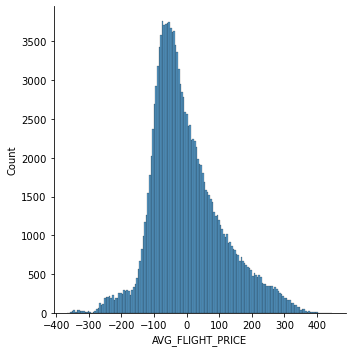

In [78]:
#Run the model

red_predict(GradientBoostingRegressor())

Model: AdaBoostRegressor()
Training r2: 0.05


Test r2: 0.05
MSE: 16516.58
RMSE: 128.52
MAE: 108.93


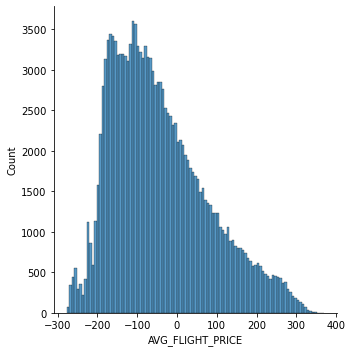

In [79]:
#Run the model

red_predict(AdaBoostRegressor())

### Model Evaluation (Outliers Removed)

The  **Random Forrest Regressor** is still the best performing model on the test data, now reaching an **R<sup>2</sup>** of 46%. Another way to look at this result is through the lens of MAE when there is an error on the prediction on average that variance is $69 dollars which isn't too far off. All models saw an increase in performance (up to 14%) with the removal of outliers. With these new results, hyperparameter optimization can occur for the top-performing model.

<img src="files/Images/model_3.png">

### Randomized Grid Search (Outliers Removed)

A new **Pipeline** has been created with hyperparameters only as scaling and PCA is complete. The **Randomized Grid Search** parameters that will be used are below. Due to the several hours required to compute this search, `cv` = 5, and there will be 5 `n_iter` for a total of 25 fittings.

<img src="files/Images/gridsearch_2.png"> 

In [82]:
# Placeholders for the series of steps we're using

pipe_estimators = [('model', RandomForestRegressor())]

red_mod_pipe = Pipeline(pipe_estimators)

In [83]:
%%time
#Hyoer-parameter tuning for the model

red_rf_grid = {'model__bootstrap': [True, False],
            'model__max_features': ['auto', 'sqrt'],
            'model__max_depth': [3, 5, 7],
            'model__min_samples_leaf': [10, 15],
            'model__n_estimators': [800, 850]}

red_model_gridsearch = RandomizedSearchCV(red_mod_pipe, param_distributions=red_rf_grid, cv=5, verbose=5, n_iter=2)
red_model_gridsearch.fit(X_red_train, y_red_train)



Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END model__bootstrap=False, model__max_depth=5, model__max_features=sqrt, model__min_samples_leaf=15, model__n_estimators=800; total time=18.0min
[CV 2/5] END model__bootstrap=False, model__max_depth=5, model__max_features=sqrt, model__min_samples_leaf=15, model__n_estimators=800; total time=18.0min
[CV 3/5] END model__bootstrap=False, model__max_depth=5, model__max_features=sqrt, model__min_samples_leaf=15, model__n_estimators=800; total time=17.9min
[CV 4/5] END model__bootstrap=False, model__max_depth=5, model__max_features=sqrt, model__min_samples_leaf=15, model__n_estimators=800; total time=17.8min
[CV 5/5] END model__bootstrap=False, model__max_depth=5, model__max_features=sqrt, model__min_samples_leaf=15, model__n_estimators=800; total time=17.8min
[CV 1/5] END model__bootstrap=True, model__max_depth=5, model__max_features=sqrt, model__min_samples_leaf=10, model__n_estimators=850; total time=13.2min
[CV 2/5] EN

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('model',
                                              RandomForestRegressor())]),
                   n_iter=2,
                   param_distributions={'model__bootstrap': [True, False],
                                        'model__max_depth': [3, 5, 7],
                                        'model__max_features': ['auto', 'sqrt'],
                                        'model__min_samples_leaf': [10, 15],
                                        'model__n_estimators': [800, 850]},
                   verbose=5)

### Best Hyperparameters

In [84]:
#The paprameters that gave the highest score

red_model_gridsearch.best_params_

{'model__n_estimators': 800,
 'model__min_samples_leaf': 15,
 'model__max_features': 'sqrt',
 'model__max_depth': 5,
 'model__bootstrap': False}

### Model R<sup>2</sup> with Optimized Parameters

The models performance decrease substantially with the use of hyperparmaters so the base model will be used instead.

In [85]:
#The score based on the best parameters

red_model_gridsearch.best_score_

0.18502470981119157

## Conclusions

<img src="files/Images/summary.png">

Can Machine Learning models and techniques be used to predict flight prices? In this assignment, it was possible to predict 46% of the test data using Machine Learning models. When there is an error in the prediction, on average, it is off by $69. Various models were attempted, such as Linear Regression, Decision Tree, Random Forest, AdaBoost and Gradient Boosting with varying results. However, Random Forest consistently outperformed the other Machine Learning Models. As discussed in class, the Scientific Process is iterative, and the data parameter needed to be re-evaluated and decisions made on dimensionality to reduce computation time and improve model performance. With the removal of 2020 and outliers, the model saw a respectable +7% and +14% increase in performance. Unfortunately, due to the data size, Randomized Grid Search needed to be leveraged to optimize performance and did not result in improved performance. In the end, the best parameters were the default model parameters. The work does not end on this project as a next step, Bokeh will be used to visualize that data and make it easy for the user to interact with the data and determine their flight cost from NYC. Additional data will also be added to improve the results of the model.

#### Footnotes:

[<sup>1</sup>](#fn1) <span id="fn1">https://www.valuepenguin.com/average-cost-vacation</sup> <br>